# Leukemia

## Function

In [1]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
#     plt.figure()
#     generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
#     plt.show()

In [2]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [3]:
def show_values(axs, orient="v", space=.01, fmt='{:.4f}', fsize=18):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = fmt.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=fsize) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = fmt.format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=fsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Library

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
import matplotlib.pyplot as plt
import xlsxwriter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter

from sklearn.metrics import confusion_matrix
import itertools

from ipynb.fs.full.DistanceWeightedKNN import DistanceWeightedKNN

In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

## Preprocessing

In [5]:
df = pd.read_csv('DATASET/LeukemiaALL-AML.csv')
df.head(10)

Class  x.AFFX.BioB.5_at  x.AFFX.BioB.M_at  x.AFFX.BioB.3_at  \
0   ALL              -214              -153               -58   
1   ALL              -139               -73                -1   
2   ALL               -76               -49              -307   
3   ALL              -135              -114               265   
4   ALL              -106              -125               -76   
5   ALL              -138               -85               215   
6   ALL               -72              -144               238   
7   ALL              -413              -260                 7   
8   ALL                 5              -127               106   
9   ALL               -88              -105                42   

   x.AFFX.BioC.5_at  x.AFFX.BioC.3_at  x.AFFX.BioDn.5_at  x.AFFX.BioDn.3_at  \
0                88              -295               -558                199   
1               283              -264               -400               -330   
2               309              -376               -650                 33   
3                12              -419               -585                158   
4               168              -230               -284                  4   
5                71              -272               -558                 67   
6                55              -399               -551                131   
7                -2              -541               -790               -275   
8               268              -210               -535                  0   
9               219              -178               -246                328   

   x.AFFX.CreX.5_at  x.AFFX.CreX.3_at  ...  x.U48730_at  x.U58516_at  \
0              -176               252  ...          185          511   
1              -168               101  ...          169          837   
2              -367               206  ...          315         1199   
3              -253                49  ...          240          835   
4              -122                70  ...          156          649   
5              -186                87  ...          115         1221   
6              -179               126  ...           30          819   
7              -463                70  ...          289          629   
8              -174                24  ...          356          980   
9              -148               177  ...           42          986   

   x.U73738_at  x.X06956_at  x.X16699_at  x.X83863_at  x.Z17240_at  \
0         -125          389          -37          793          329   
1          -36          442          -17          782          295   
2           33          168           52         1138          777   
3          218          174         -110          627          170   
4           57          504          -26          250          314   
5          -76          172          -74          645          341   
6         -178          151          -18         1140          482   
7          -86          302           23         1799          446   
8            6          177          -12          758          385   
9           26          101           21          570          359   

   x.L49218_f_at  x.M71243_f_at  x.Z78285_f_at  
0             36            191            -37  
1             11             76            -14  
2             41            228            -41  
3            -50            126            -91  
4             14             56            -25  
5             26            193            -53  
6             10            369            -42  
7             59            781             20  
8            115            244            -39  
9              9            171              7  

[10 rows x 7130 columns]

In [6]:
#jumlah class
df.Class.value_counts()

ALL    47
AML    25
Name: Class, dtype: int64

C:\Anaconda\envs\jcopml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "legend" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app
2022-07-18 16:57:13,224 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,226 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,484 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,486 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,513 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,516 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,591 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 16:57:13,594 - matplotlib.text - WARNING - posx and posy should be

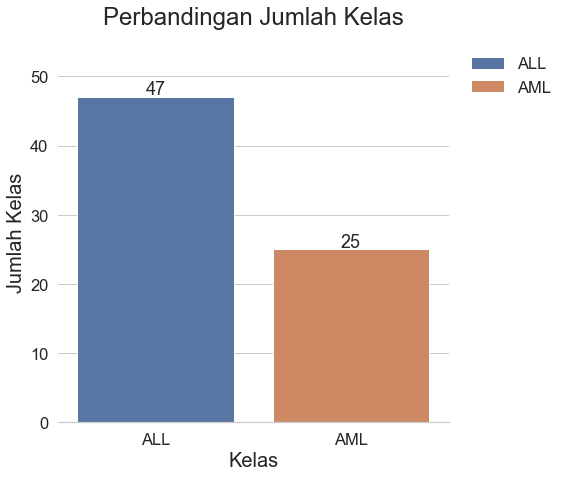

In [7]:
plt.figure(figsize=(7,7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.countplot(x=df.Class, hue=df.Class, dodge=False, data=df)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Kelas', fontsize=24, y=1.03)
p.set_ylabel('Jumlah Kelas', fontsize=20)
p.set_xlabel('Kelas', fontsize=20)
p.set_ylim(0, 55)
# plt.legend(labels=['Tumor', 'Normal'], frameon=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labels=['ALL', 'AML'], frameon=False)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/JumlahClass.png', legend=p.get_legend)

In [8]:
encode = LabelEncoder()
df['Class'] = encode.fit_transform(df['Class'])
df.Class.value_counts()

0    47
1    25
Name: Class, dtype: int64

In [9]:
class_names = np.unique(df.Class)
class_names

array([0, 1])

In [10]:
X = df.drop(columns='Class').values
y = df.Class.values
print(Counter(y))

Counter({0: 47, 1: 25})


In [11]:
#normalisasi
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X)

0         1         2         3         4         5         6     \
0   0.466192  0.729730  0.487535  0.265525  0.375573  0.366279  0.708071   
1   0.599644  0.884170  0.566482  0.683084  0.422901  0.595930  0.405266   
2   0.711744  0.930502  0.142659  0.738758  0.251908  0.232558  0.613051   
3   0.606762  0.805019  0.934903  0.102784  0.186260  0.327035  0.684602   
4   0.658363  0.783784  0.462604  0.436831  0.474809  0.764535  0.596451   
..       ...       ...       ...       ...       ...       ...       ...   
67  0.736655  0.642857  0.560942  0.379015  0.435115  0.877907  0.423583   
68  0.743772  0.606178  0.655125  0.280514  0.534351  0.843023  0.544934   
69  0.560498  0.610039  0.504155  0.389722  0.563359  0.311047  0.524327   
70  0.761566  0.000000  0.396122  1.000000  0.068702  0.165698  0.000000   
71  0.533808  0.476834  0.455679  0.096360  0.377099  0.460756  0.369204   

        7         8         9     ...      7119      7120      7121      7122  \
0   0.634956  0.928074  0.500743  ...  0.515924  0.268886  0.331384  0.161897   
1   0.652655  0.577726  0.402675  ...  0.481953  0.477593  0.504873  0.182673   
2   0.212389  0.821346  0.187964  ...  0.791932  0.709347  0.639376  0.075265   
3   0.464602  0.457077  0.370728  ...  0.632696  0.476312  1.000000  0.077617   
4   0.754425  0.505800  0.534918  ...  0.454352  0.357234  0.686160  0.206978   
..       ...       ...       ...  ...       ...       ...       ...       ...   
67  0.542035  0.310905  0.421991  ...  0.318471  0.282330  0.508772  0.103097   
68  0.688053  0.329466  0.162704  ...  0.256900  0.131882  0.645224  0.149745   
69  0.269912  0.740139  0.238484  ...  0.399151  0.350832  0.522417  0.224226   
70  0.048673  0.888631  0.464339  ...  0.301486  0.672215  0.339181  0.086633   
71  0.712389  0.728538  0.320208  ...  0.295117  0.309219  0.832359  0.251666   

        7123      7124      7125      7126      7127      7128  
0   0.672794  0.322954  0.322328  0.754658  0.079423  0.570896  
1   0.746324  0.318060  0.292789  0.677019  0.044158  0.656716  
2   1.000000  0.476423  0.711555  0.770186  0.090770  0.555970  
3   0.404412  0.249110  0.184188  0.487578  0.059491  0.369403  
4   0.713235  0.081406  0.309296  0.686335  0.038025  0.615672  
..       ...       ...       ...       ...       ...       ...  
67  0.522059  0.284698  0.344049  0.574534  0.100583  0.727612  
68  0.816176  0.158363  0.072111  0.642857  0.565777  0.526119  
69  0.665441  0.330071  0.423110  0.636646  0.085250  0.768657  
70  0.411765  0.177491  0.339705  0.642857  0.107942  0.436567  
71  0.775735  0.215302  0.205039  0.704969  0.137075  0.485075  

[72 rows x 7129 columns]

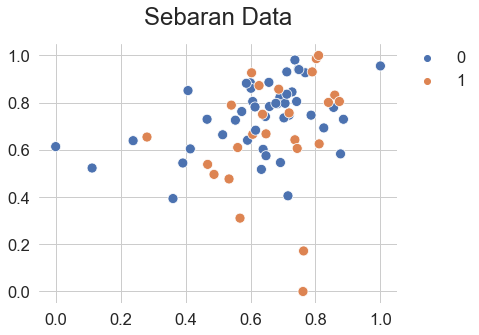

In [12]:
plt.figure(figsize=(7, 5))
plt.rcParams['figure.autolayout'] = True
sns.set_style('whitegrid')
p = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, s=100)
p.set_title('Sebaran Data', fontsize=24, y=1.05)
sns.despine(left=True, bottom=True)
p_fig = p.get_figure()
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/ScatterPlot.png')

# SELEKSI FITUR

## Fold (2-10)

In [115]:
fs_mdl = np.zeros(11)
fs_acc = np.zeros(11)
fs_prc = np.zeros(11)
fs_rcl = np.zeros(11)
fs_f1 = np.zeros(11)
ftr = np.zeros(11)
fs_pos = []
fs_pred = []
fs_act = []

X_train_fold = []
y_train_fold = []
X_test_fold = []
y_test_fold = []

for a in range(2, 11):
    print("FOLD :", a)

    #split menggunakan kfold
    folds = StratifiedKFold(n_splits=a, shuffle=True, random_state=42)

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in folds.split(X, y):
        X_train.append(X[train_index]), X_test.append(X[test_index]), y_train.append(y[train_index]), y_test.append(y[test_index])

    for i in range(folds.n_splits):
        print(Counter(y_train[i]))

    X_train_fold.append(X_train)
    y_train_fold.append(y_train)
    X_test_fold.append(X_test)
    y_test_fold.append(y_test)

    #modeling
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    #seleksi fitur BPSO
    def f_per_particle(m, alpha):
        total_features = X.shape[1]
        scores = np.zeros(folds.n_splits)

        for i in range(folds.n_splits):
            if np.count_nonzero(m) == 0:
                X_subset = X_train[i]
            else:
                X_subset = X_train[i][:,m==1]

            model.fit(X_subset, y_train[i])
            pred = model.predict(X_subset)
            scores[i] = accuracy_score(y_train[i], pred)

        P = np.mean(scores)

        j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
        return j

    def f(x, alpha=0.88):
        n_particles = x.shape[0]
        j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
        return np.array(j)

    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 30, 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    fs_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(folds.n_splits)
    acc_scr = np.zeros(folds.n_splits)
    prc_scr = np.zeros(folds.n_splits)
    rcl_scr = np.zeros(folds.n_splits)
    f1_scr = np.zeros(folds.n_splits)
    pred_scr = []
    act_scr = []

    for i in range(folds.n_splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)
        pred_scr.append(pred)
        act_scr.append(y_test[i])

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)


    #collect acc, prc, rcl, f1 BPSO
    fs_mdl[a-1] = np.mean(mdl_scr)
    fs_acc[a-1] = np.mean(acc_scr)
    fs_prc[a-1] = np.mean(prc_scr)
    fs_rcl[a-1] = np.mean(rcl_scr)
    fs_f1[a-1] = np.mean(f1_scr)
    ftr[a-1] = np.count_nonzero(pos)
    fs_pred.append(pred_scr)
    fs_act.append(act_scr)    


ind_fs = np.argmax(fs_acc)
print('---------- BPSO ----------')
print('Fold : ', ind_fs+1)
print('Accuracy Model : %0.4f'%(fs_mdl[ind_fs]))
print('Mean Accuracy: %0.4f'%(np.max(fs_acc)))
print('Mean Precision: %0.4f'%(fs_prc[ind_fs]))
print('Mean Recall: %0.4f'%(fs_rcl[ind_fs]))
print('Mean F1: %0.4f'%(fs_f1[ind_fs]))

2022-07-18 19:00:51,240 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 2
Counter({0: 23, 1: 13})
Counter({0: 24, 1: 12})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 19:00:55,361 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05645672604853415, best pos: [0 0 0 ... 0 1 0]
2022-07-18 19:00:55,443 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 3
Counter({0: 31, 1: 17})
Counter({0: 31, 1: 17})
Counter({0: 32, 1: 16})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:01:03,198 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05681021181091317, best pos: [1 0 0 ... 1 0 0]
2022-07-18 19:01:03,302 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 4
Counter({0: 35, 1: 19})
Counter({0: 35, 1: 19})
Counter({0: 35, 1: 19})
Counter({0: 36, 1: 18})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:01:14,390 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057113199607238034, best pos: [1 1 1 ... 1 0 1]
2022-07-18 19:01:14,522 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 5
Counter({0: 37, 1: 20})
Counter({0: 37, 1: 20})
Counter({0: 38, 1: 20})
Counter({0: 38, 1: 20})
Counter({0: 38, 1: 20})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0569
2022-07-18 19:01:29,266 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056944873053724226, best pos: [1 1 0 ... 0 0 0]
2022-07-18 19:01:29,416 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 6
Counter({0: 39, 1: 21})
Counter({0: 39, 1: 21})
Counter({0: 39, 1: 21})
Counter({0: 39, 1: 21})
Counter({0: 39, 1: 21})
Counter({0: 40, 1: 20})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 19:01:47,501 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056625052602047976, best pos: [0 0 0 ... 1 1 0]
2022-07-18 19:01:47,651 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 7
Counter({0: 40, 1: 21})
Counter({0: 40, 1: 21})
Counter({0: 40, 1: 22})
Counter({0: 40, 1: 22})
Counter({0: 40, 1: 22})
Counter({0: 41, 1: 21})
Counter({0: 41, 1: 21})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0569
2022-07-18 19:02:09,317 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056928040398372834, best pos: [1 0 1 ... 1 1 1]
2022-07-18 19:02:09,491 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 8
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 41, 1: 22})
Counter({0: 42, 1: 21})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:02:34,980 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056759713844859026, best pos: [1 1 1 ... 1 0 1]
2022-07-18 19:02:35,178 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 9
Counter({0: 41, 1: 23})
Counter({0: 41, 1: 23})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:03:03,297 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05734885678215738, best pos: [1 0 0 ... 0 1 0]
2022-07-18 19:03:03,510 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 10
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 22})
Counter({0: 42, 1: 23})
Counter({0: 42, 1: 23})
Counter({0: 42, 1: 23})
Counter({0: 42, 1: 23})
Counter({0: 42, 1: 23})
Counter({0: 43, 1: 22})
Counter({0: 43, 1: 22})
Counter({0: 43, 1: 22})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:03:35,076 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05721419553934633, best pos: [0 1 1 ... 1 1 1]


---------- BPSO ----------
Fold :  7
Accuracy Model : 1.0000
Mean Accuracy: 0.9169
Mean Precision: 0.9235
Mean Recall: 0.9592
Mean F1: 0.9370


Confusion matrix, without normalization


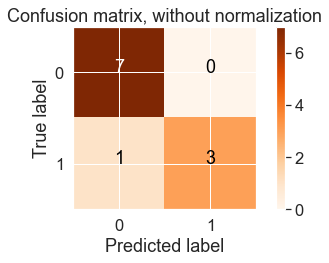

Confusion matrix, without normalization


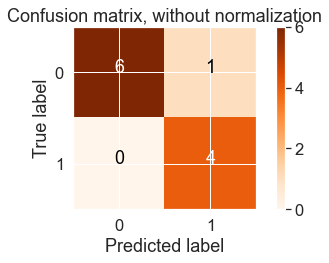

Confusion matrix, without normalization


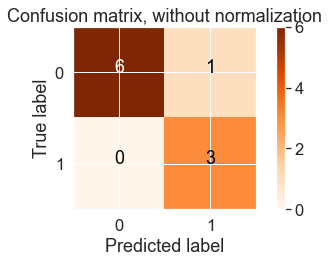

Confusion matrix, without normalization


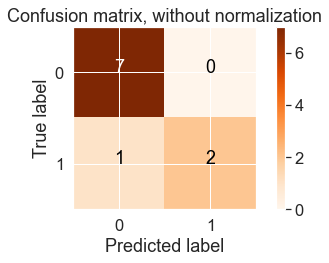

Confusion matrix, without normalization


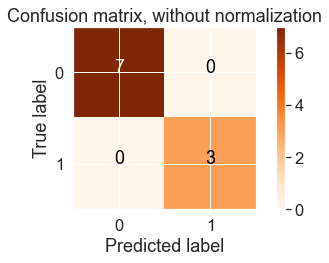

Confusion matrix, without normalization


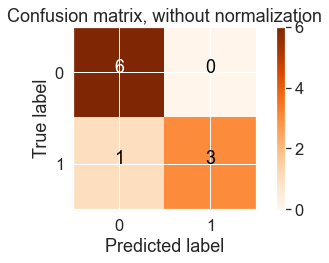

Confusion matrix, without normalization


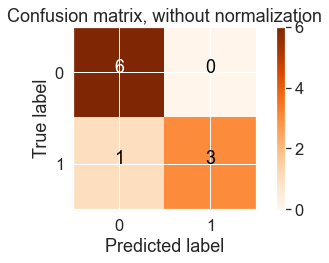

In [116]:
for i in range(ind_fs+1):
    plot_confusion_matrix(fs_pred[ind_fs-1][i], fs_act[ind_fs-1][i])

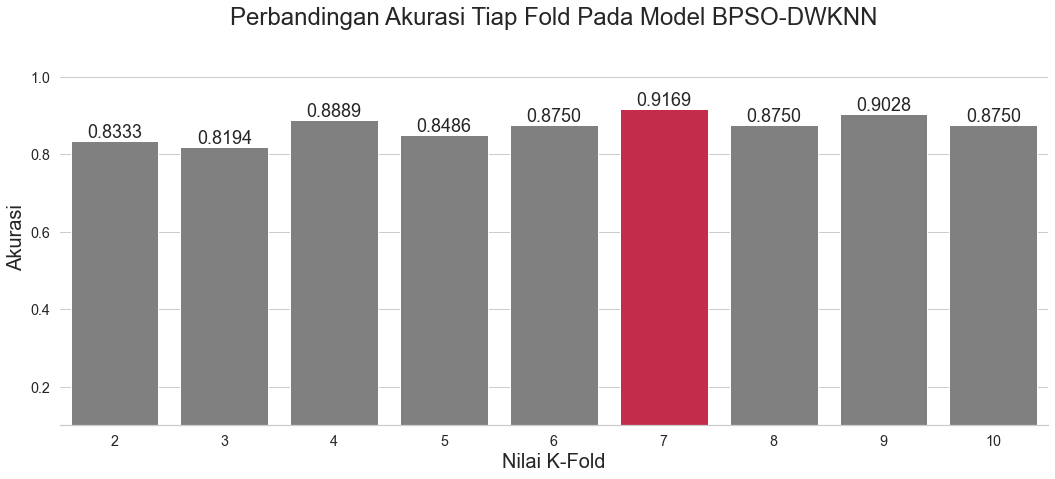

In [117]:
fold = [2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(fs_acc[1:10])) else 'crimson' for x in fs_acc[1:10]]
p = sns.barplot(x=fold, y=fs_acc[1:10], palette=clr)
sns.despine(left=True)
p.set_title('Perbandingan Akurasi Tiap Fold Pada Model BPSO-DWKNN', fontsize=24, y=1.05)
p.set_xlabel("Nilai K-Fold", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.5)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/FoldWithBPSO.png')

In [118]:
fld = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
fold_fs_df = pd.DataFrame({'Fold': fld[1:10],
                       'AkurasiTrain': np.round(fs_mdl[1:10], 4),
                      'AkurasiTest': np.round(fs_acc[1:10], 4),
                      'Presisi': np.round(fs_prc[1:10], 4),
                      'Recall': np.round(fs_rcl[1:10], 4),
                      'F1-Score': np.round(fs_f1[1:10], 4),
                           'JumlahFitur': ftr[1:10],
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

fold_fs_df.style.set_table_styles(dfstyle).hide_index()

In [238]:
fs_pos_df = pd.DataFrame(fs_pos)
fs_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LeukemiaFoldPOS.csv')

## Pembagian Data

In [166]:
X_train = X_train_fold[ind_fs-1]
y_train = y_train_fold[ind_fs-1] 
X_test =  X_test_fold[ind_fs-1]
y_test = y_test_fold[ind_fs-1]

In [167]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

7 7 7 7


## C1, C2, W

In [133]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')
splits = ind_fs+1

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

w = 0.9
c1 = [1, 1.25, 1.5, 1.75, 2]
c2 = [1, 1.25, 1.5, 1.75, 2]
wth, hgh = 5, 5
w0_acc = [[0 for x in range(wth)] for y in range(hgh)] 
w1_acc = [[0 for x in range(wth)] for y in range(hgh)]
c1c2_pos = []
for it in range(2):
    m = 0
    for _c1 in range(len(c1)):
        n = 0
        for _c2 in range(len(c2)):
                #inisiasiBPSO
                ps.discrete.BinaryPSO

                #executeBPSO
                options = {'c1': c1[_c1], 'c2': c2[_c2], 'w':w, 'k': 30, 'p':2}
                dimensions = X.shape[1]
                optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
                cost, pos = optimizer.optimize(f, iters=10, verbose=3)
                
                c1c2_pos.append(pos)

                #model
                model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

                mdl_scr = np.zeros(splits)
                acc_scr = np.zeros(splits)
                prc_scr = np.zeros(splits)
                rcl_scr = np.zeros(splits)
                f1_scr = np.zeros(splits)

                for i in range(splits):
                    X_train_selected = X_train[i][:,pos==1]
                    X_test_selected = X_test[i][:,pos==1]

                    #fit
                    model.fit(X_train_selected, y_train[i])

                    #predict
                    pred = model.predict(X_test_selected)

                    #accuracy
                    mdl_scr[i] = model.score(X_train_selected, y_train[i])
                    acc_scr[i] = accuracy_score(y_test[i], pred)
                    prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
                    rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
                    f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
                if w == 0.9:
                    w0_acc[m][n] = np.round(np.mean(acc_scr), 4)
                else:
                    w1_acc[m][n] = np.round(np.mean(acc_scr), 4)
                n+=1
                print('c1 = ', c1[_c1], 'c2 = ', c2[_c2], 'w = ', w)
                print('Dengan Seleksi Fitur BPSO')
                print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))
        m+=1
    w+=0.1

2022-07-18 19:27:01,137 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 19:27:18,243 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05768550988918501, best pos: [1 1 0 ... 1 1 0]
2022-07-18 19:27:18,397 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3702


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 19:27:39,982 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058005330340861264, best pos: [1 1 1 ... 1 1 0]
2022-07-18 19:27:40,121 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3683


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:28:01,338 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057197362883994955, best pos: [0 1 0 ... 1 0 0]
2022-07-18 19:28:01,491 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3731


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 19:28:22,984 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763501192313087, best pos: [1 1 1 ... 0 1 0]
2022-07-18 19:28:23,137 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3705


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 19:28:44,362 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05741618740356291, best pos: [0 1 0 ... 0 1 0]
2022-07-18 19:28:44,550 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3718


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:29:07,351 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05677654650021041, best pos: [0 1 1 ... 0 0 1]
2022-07-18 19:29:07,492 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3756


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 19:29:29,913 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05756768130172535, best pos: [0 0 0 ... 1 0 0]
2022-07-18 19:29:30,094 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3709


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:29:53,191 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057332024126806005, best pos: [1 1 1 ... 0 1 1]
2022-07-18 19:29:53,362 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3723


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 19:30:16,191 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05741618740356291, best pos: [1 1 0 ... 1 1 1]
2022-07-18 19:30:16,338 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3718


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:30:37,760 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05709636695188666, best pos: [0 1 1 ... 0 1 0]
2022-07-18 19:30:37,899 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9169 	 Presisi:  0.9235 	 Recall: 0.9592 	 F1 Score: 0.937 	 Fitur Terpilih: 3737


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 19:30:59,780 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058106326272969556, best pos: [0 0 1 ... 0 1 0]
2022-07-18 19:30:59,937 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8896 	 Presisi:  0.8957 	 Recall: 0.9592 	 F1 Score: 0.9203 	 Fitur Terpilih: 3677


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 19:31:22,037 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05750035068031981, best pos: [0 0 0 ... 1 1 1]
2022-07-18 19:31:22,274 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9169 	 Presisi:  0.9235 	 Recall: 0.9592 	 F1 Score: 0.937 	 Fitur Terpilih: 3713


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:31:44,064 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057113199607238034, best pos: [1 0 0 ... 1 1 1]
2022-07-18 19:31:44,236 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8896 	 Presisi:  0.8892 	 Recall: 0.9592 	 F1 Score: 0.9192 	 Fitur Terpilih: 3736


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 19:32:00,355 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05736568943750876, best pos: [1 0 1 ... 1 1 1]
2022-07-18 19:32:00,461 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3721


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 19:32:14,395 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05674288118950764, best pos: [1 1 1 ... 0 1 1]
2022-07-18 19:32:14,496 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8753 	 Presisi:  0.8753 	 Recall: 0.9592 	 F1 Score: 0.9109 	 Fitur Terpilih: 3758


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:32:29,040 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05707953429653528, best pos: [1 1 1 ... 1 1 0]
2022-07-18 19:32:29,143 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9169 	 Presisi:  0.9235 	 Recall: 0.9592 	 F1 Score: 0.937 	 Fitur Terpilih: 3738


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:32:44,186 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057197362883994955, best pos: [0 1 0 ... 0 1 0]
2022-07-18 19:32:44,323 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3731


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 19:32:59,755 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057954832374807114, best pos: [1 0 1 ... 1 1 0]
2022-07-18 19:32:59,885 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9235 	 Recall: 0.9388 	 F1 Score: 0.9242 	 Fitur Terpilih: 3686


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 19:33:16,351 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05647355870388553, best pos: [0 0 1 ... 0 0 0]
2022-07-18 19:33:16,470 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3774


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:33:36,924 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056759713844859026, best pos: [0 1 1 ... 1 0 1]
2022-07-18 19:33:37,089 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3757


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 19:34:01,578 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057786505821293306, best pos: [0 1 0 ... 0 0 0]
2022-07-18 19:34:01,753 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3696


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:34:31,122 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05706270164118389, best pos: [0 1 1 ... 1 1 1]
2022-07-18 19:34:31,282 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3739


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:34:55,397 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05721419553934633, best pos: [0 1 1 ... 1 0 1]
2022-07-18 19:34:55,579 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3730


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 19:35:18,558 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0565072240145883, best pos: [0 1 0 ... 0 1 0]
2022-07-18 19:35:18,699 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3772


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0567
2022-07-18 19:35:40,443 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056709215878804876, best pos: [0 0 1 ... 0 0 0]
2022-07-18 19:35:40,584 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.93 	 Recall: 0.9388 	 F1 Score: 0.9268 	 Fitur Terpilih: 3760


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 19:36:05,408 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05793799971945574, best pos: [0 1 0 ... 1 1 0]
2022-07-18 19:36:05,588 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8896 	 Presisi:  0.8892 	 Recall: 0.9592 	 F1 Score: 0.9192 	 Fitur Terpilih: 3687


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:36:29,890 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057197362883994955, best pos: [1 1 0 ... 1 0 1]
2022-07-18 19:36:30,060 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3731


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 19:36:55,190 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057012203675129755, best pos: [0 1 1 ... 0 1 1]
2022-07-18 19:36:55,369 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3742


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:37:19,603 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056759713844859026, best pos: [0 1 0 ... 1 0 0]
2022-07-18 19:37:19,773 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3757


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:37:43,124 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057197362883994955, best pos: [1 0 1 ... 1 0 0]
2022-07-18 19:37:43,291 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3731


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 19:38:08,559 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05768550988918501, best pos: [0 1 0 ... 0 1 0]
2022-07-18 19:38:08,724 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3702


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 19:38:33,009 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05748351802496844, best pos: [0 0 0 ... 1 1 1]
2022-07-18 19:38:33,154 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3714


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 19:38:55,526 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056625052602047976, best pos: [1 1 1 ... 0 1 1]
2022-07-18 19:38:55,671 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3765


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0568
2022-07-18 19:39:17,894 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056793379155561784, best pos: [0 0 0 ... 1 1 0]
2022-07-18 19:39:18,001 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8753 	 Presisi:  0.8892 	 Recall: 0.9388 	 F1 Score: 0.9064 	 Fitur Terpilih: 3755


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:39:39,899 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05734885678215738, best pos: [1 0 0 ... 0 0 1]
2022-07-18 19:39:40,076 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8896 	 Presisi:  0.8957 	 Recall: 0.9592 	 F1 Score: 0.9203 	 Fitur Terpilih: 3722


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 19:40:03,257 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057146864917940805, best pos: [1 0 1 ... 1 0 1]
2022-07-18 19:40:03,443 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9039 	 Presisi:  0.8957 	 Recall: 0.9796 	 F1 Score: 0.9313 	 Fitur Terpilih: 3734


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 19:40:27,631 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05753401599102258, best pos: [1 1 0 ... 1 0 1]
2022-07-18 19:40:27,784 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9039 	 Presisi:  0.9161 	 Recall: 0.9592 	 F1 Score: 0.9313 	 Fitur Terpilih: 3711


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 19:40:50,442 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05699537101977837, best pos: [1 1 1 ... 0 1 0]
2022-07-18 19:40:50,597 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3743


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0561
2022-07-18 19:41:13,768 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.056086407630803754, best pos: [0 1 1 ... 0 1 1]
2022-07-18 19:41:13,916 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3797


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0559
2022-07-18 19:41:29,913 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.055901248421938554, best pos: [1 0 0 ... 1 1 1]
2022-07-18 19:41:30,015 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3808


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 19:41:47,633 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057954832374807114, best pos: [0 0 1 ... 0 0 0]
2022-07-18 19:41:47,774 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9169 	 Presisi:  0.9235 	 Recall: 0.9592 	 F1 Score: 0.937 	 Fitur Terpilih: 3686


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 19:42:08,799 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05776967316594192, best pos: [0 1 0 ... 0 1 1]
2022-07-18 19:42:08,957 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3697


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 19:42:28,983 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05721419553934633, best pos: [1 0 0 ... 0 0 0]
2022-07-18 19:42:29,123 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3730


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 19:42:49,222 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05748351802496844, best pos: [1 0 1 ... 0 0 1]
2022-07-18 19:42:49,379 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3714


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0566
2022-07-18 19:43:11,620 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05664188525739935, best pos: [1 0 0 ... 0 1 0]
2022-07-18 19:43:11,787 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3764


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 19:43:31,974 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057651844578482256, best pos: [0 1 0 ... 1 0 1]
2022-07-18 19:43:32,074 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3704


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 19:43:48,428 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05780333847664469, best pos: [0 1 1 ... 0 1 0]
2022-07-18 19:43:48,563 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3695


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:44:09,277 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057281526160751856, best pos: [0 1 1 ... 0 0 0]
2022-07-18 19:44:09,443 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9312 	 Presisi:  0.93 	 Recall: 0.9796 	 F1 Score: 0.9506 	 Fitur Terpilih: 3726


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:44:29,324 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057298358816103234, best pos: [0 0 1 ... 1 1 0]
2022-07-18 19:44:29,446 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8896 	 Presisi:  0.8957 	 Recall: 0.9592 	 F1 Score: 0.9203 	 Fitur Terpilih: 3725


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0565
2022-07-18 19:44:44,016 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05649039135923692, best pos: [1 0 1 ... 0 0 1]


c1 =  2 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8883 	 Presisi:  0.9096 	 Recall: 0.9388 	 F1 Score: 0.9158 	 Fitur Terpilih: 3773


In [139]:
w0_df = pd.DataFrame(w0_acc)
w0_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w0_df.index = ['1', '1.25', '1.5', '1.75', '2']

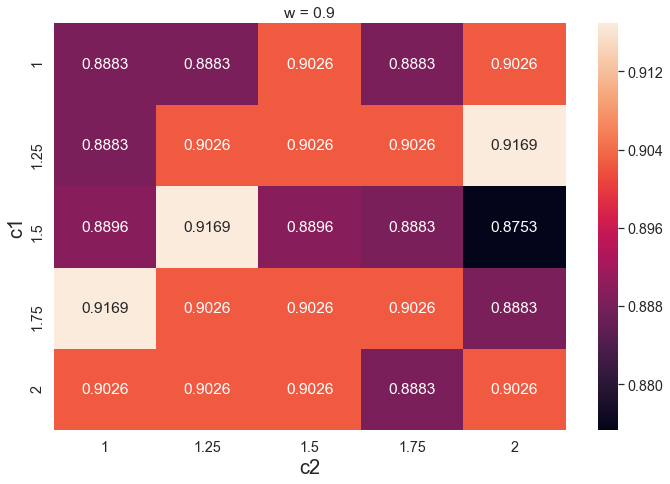

In [140]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w0 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w0_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w0.set_title(label= 'w = 0.9');
par_w0.set_xlabel('c2', fontdict=ft)
par_w0.set_ylabel('c1', fontdict=ft)
p_fig = par_w0.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/C1C2W09.png')

In [141]:
w1_df = pd.DataFrame(w1_acc)
w1_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w1_df.index = ['1', '1.25', '1.5', '1.75', '2']

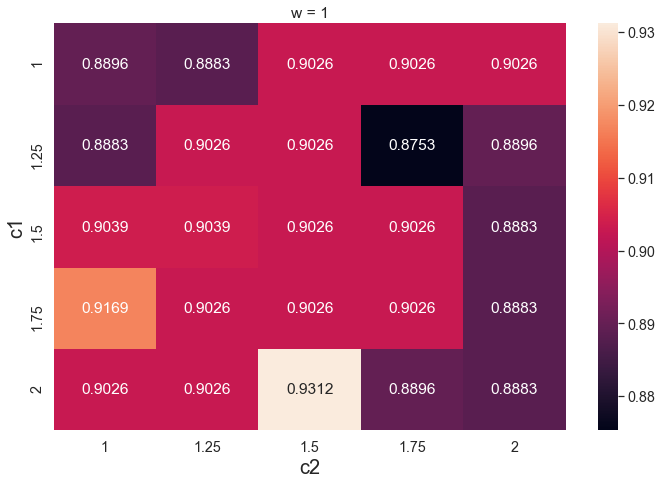

In [142]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w1 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w1_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w1.set_title(label= 'w = 1');
par_w1.set_xlabel('c2', fontdict=ft)
par_w1.set_ylabel('c1', fontdict=ft)
p_fig = par_w1.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/C1C2W1.png')

In [239]:
c1c2_pos_df = pd.DataFrame(c1c2_pos)
c1c2_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LeukemiaC1C2POS.csv')

## Population

In [169]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

prt = [10, 20, 30, 50]

pop_mdl = np.zeros(len(prt))
pop_acc = np.zeros(len(prt))
pop_prc = np.zeros(len(prt))
pop_rcl = np.zeros(len(prt))
pop_f1 = np.zeros(len(prt))
pop_pos = []

for k in range(len(prt)):
    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 2, 'c2': 1.5, 'w': 1, 'k': prt[k], 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=prt[k], dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)
    
    pop_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(splits)
    acc_scr = np.zeros(splits)
    prc_scr = np.zeros(splits)
    rcl_scr = np.zeros(splits)
    f1_scr = np.zeros(splits)

    for i in range(splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
    
    pop_mdl[k] = np.mean(mdl_scr)
    pop_acc[k] = np.mean(acc_scr)
    pop_prc[k] = np.mean(prc_scr)
    pop_rcl[k] = np.mean(rcl_scr)
    pop_f1[k] = np.mean(f1_scr)   
    
    print('Population:', prt[k])
    print('Dengan Seleksi Fitur BPSO')
    print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))

2022-07-18 21:12:20,938 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 21:12:27,917 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763501192313087, best pos: [1 0 1 ... 0 0 1]
2022-07-18 21:12:28,067 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1, 'k': 20, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 10
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.874 	 Presisi:  0.8858 	 Recall: 0.9388 	 F1 Score: 0.9067 	 Fitur Terpilih: 3705


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 21:12:42,087 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05706270164118389, best pos: [1 0 1 ... 1 1 0]
2022-07-18 21:12:42,225 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 20
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9026 	 Presisi:  0.9096 	 Recall: 0.9592 	 F1 Score: 0.9287 	 Fitur Terpilih: 3739


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 21:13:02,921 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05721419553934633, best pos: [0 1 1 ... 1 0 0]
2022-07-18 21:13:03,060 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1, 'k': 50, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 30
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9169 	 Presisi:  0.9235 	 Recall: 0.9592 	 F1 Score: 0.937 	 Fitur Terpilih: 3730


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0562
2022-07-18 21:13:37,478 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05620423621826343, best pos: [1 0 0 ... 1 1 0]


Population: 50
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8753 	 Presisi:  0.8892 	 Recall: 0.9388 	 F1 Score: 0.9064 	 Fitur Terpilih: 3790


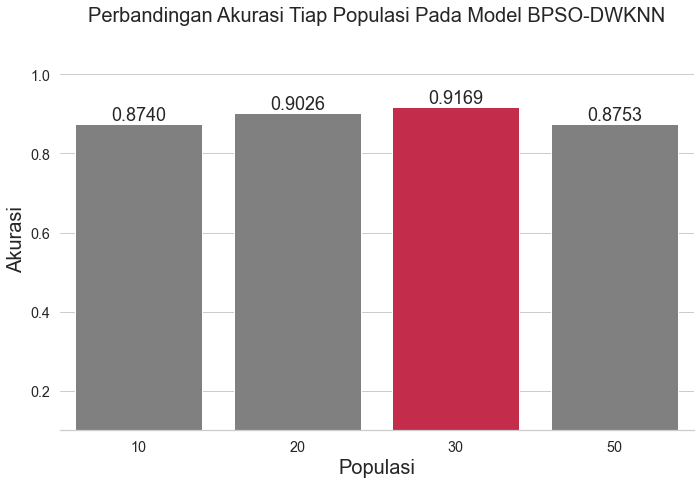

In [170]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(pop_acc)) else 'crimson' for x in pop_acc]
p = sns.barplot(x=prt, y=pop_acc, palette=clr)
p.set_title('Perbandingan Akurasi Tiap Populasi Pada Model BPSO-DWKNN', fontsize=20, y=1.05)
sns.despine(left=True)
p.set_xlabel("Populasi", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Populasi.png')

In [171]:
pop = [10, 20, 30, 50]
pop_ftr = [np.count_nonzero(pop_pos[0]), np.count_nonzero(pop_pos[1]), np.count_nonzero(pop_pos[2]), np.count_nonzero(pop_pos[3])]
pop_df = pd.DataFrame({'Populasi': pop,
                       'AkurasiTrain': np.round(pop_mdl, 4),
                      'AkurasiTest': np.round(pop_acc, 4),
                      'Presisi': np.round(pop_prc, 4),
                      'Recall': np.round(pop_rcl, 4),
                      'F1-Score': np.round(pop_f1, 4),
                       'JumlahFitur': pop_ftr,
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

pop_df.style.set_table_styles(dfstyle).hide_index()

In [240]:
pop_pos_df = pd.DataFrame(pop_pos)
pop_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LeukemiaPopPOS.csv')

In [249]:
col = df.columns[1:].values
fitur_df = pd.DataFrame(col[pop_pos[2]==1])
fitur_n_df = pd.DataFrame(col[pop_pos[2]==0])
fitur_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Leukemia(FiturTerpilih).csv')
fitur_n_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Leukemia(FiturDihapus).csv')

In [173]:
np.argmax(pop_acc)

2

# KLASIFIKASI

In [270]:
kfld_mdl = []
kfld_acc = []
kfld_prc = []
kfld_rcl = []
kfld_f1 = []
kfld_pred = []
kfld_act = []

kfld_d_mdl = []
kfld_d_acc = []
kfld_d_prc = []
kfld_d_rcl = []
kfld_d_f1 = []
kfld_d_pred = []
kfld_d_act = []

In [271]:
print(np.argmax(pop_acc))

for a in range(9):
    print("FOLD :", a+2)
    X_train = X_train_fold[a]
    y_train = y_train_fold[a] 
    X_test =  X_test_fold[a]
    y_test = y_test_fold[a]

#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    
    range_k0 = []

    kf_mdl = []
    kf_acc = []
    kf_prc = []
    kf_rcl = []
    kf_f1 = []
    kf_pred = []
    kf_act = []

    kfd_mdl = []
    kfd_acc = []
    kfd_prc = []
    kfd_rcl = []
    kfd_f1 = []
    kfd_pred = []
    kfd_act = []

    for k in range(1, 21):
        
        range_k0.append(k)
        model = DistanceWeightedKNN(n_neighbors=k, algorithm='brute')
        
        # BPSO-DWKNN
        mdl_scr = np.zeros(a+2)
        acc_scr = np.zeros(a+2)
        prc_scr = np.zeros(a+2)
        rcl_scr = np.zeros(a+2)
        f1_scr = np.zeros(a+2)
        
        pred_scr = []
        act_scr = []
        for i in range(a+2):
            
            X_train_selected = X_train[i][:,pop_pos[np.argmax(pop_acc)]==1]
            X_test_selected = X_test[i][:,pop_pos[np.argmax(pop_acc)]==1]

            #fit
            model.fit(X_train_selected, y_train[i])

            #predict
            pred = model.predict(X_test_selected)
            pred_scr.append(pred)
            act_scr.append(y_test[i])

            #accuracy
            mdl_scr[i] = model.score(X_train_selected, y_train[i])
            acc_scr[i] = accuracy_score(y_test[i], pred)
            prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
        
        # DWKNN
        _mdl_scr = np.zeros(a+2)
        _acc_scr = np.zeros(a+2)
        _prc_scr = np.zeros(a+2)
        _rcl_scr = np.zeros(a+2)
        _f1_scr = np.zeros(a+2)
            
        _pred_scr = []
        _act_scr = []
        for i in range(a+2):
            #fit
            model.fit(X_train[i], y_train[i])

            #predict
            pred = model.predict(X_test[i])
            _pred_scr.append(pred)
            _act_scr.append(y_test[i])

            #accuracy
            _mdl_scr[i] = model.score(X_train[i], y_train[i])
            _acc_scr[i] = accuracy_score(y_test[i], pred)
            _prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            _rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            _f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)

        # BPSO-DWKNN
        kf_mdl.append(np.round(np.mean(mdl_scr),4))
        kf_acc.append(np.round(np.mean(acc_scr),4))
        kf_prc.append(np.round(np.mean(prc_scr),4))
        kf_rcl.append(np.round(np.mean(rcl_scr),4))
        kf_f1.append(np.round(np.mean(f1_scr),4))
        kf_pred.append(pred_scr)
        kf_act.append(act_scr)

        # DWKNN
        kfd_mdl.append(np.round(np.mean(_mdl_scr),4))
        kfd_acc.append(np.round(np.mean(_acc_scr),4))
        kfd_prc.append(np.round(np.mean(_prc_scr),4))
        kfd_rcl.append(np.round(np.mean(_rcl_scr),4))
        kfd_f1.append(np.round(np.mean(_f1_scr),4))
        kfd_pred.append(_pred_scr)
        kfd_act.append(_act_scr)
#     print(len(kfld_acc))
    if len(kfld_acc) < 9:
        # BPSO-DWKNN 
        kfld_mdl.append(kf_mdl)
        kfld_acc.append(kf_acc)
        kfld_prc.append(kf_prc)
        kfld_rcl.append(kf_rcl)
        kfld_f1.append(kf_f1)
        kfld_pred.append(kf_pred)
        kfld_act.append(kf_act)

        # DWKNN
        kfld_d_mdl.append(kfd_mdl)
        kfld_d_acc.append(kfd_acc)
        kfld_d_prc.append(kfd_prc)
        kfld_d_rcl.append(kfd_rcl)
        kfld_d_f1.append(kfd_f1)
        kfld_d_pred.append(kfd_pred)
        kfld_d_act.append(kfd_act)
    else:
        for z in range(len(kf_mdl)):
            # BPSO-DWKNN 
            kfld_mdl[a].append(kf_mdl[z])
            kfld_acc[a].append(kf_acc[z])
            kfld_prc[a].append(kf_prc[z])
            kfld_rcl[a].append(kf_rcl[z])
            kfld_f1[a].append(kf_f1[z])
            kfld_pred[a].append(kf_pred[z])
            kfld_act[a].append(kf_act[z])

            # DWKNN
            kfld_d_mdl[a].append(kfd_mdl[z])
            kfld_d_acc[a].append(kfd_acc[z])
            kfld_d_prc[a].append(kfd_prc[z])
            kfld_d_rcl[a].append(kfd_rcl[z])
            kfld_d_f1[a].append(kfd_f1[z])
            kfld_d_pred[a].append(kfd_pred[z])
            kfld_d_act[a].append(kfd_act[z])

2
FOLD : 2
FOLD : 3
FOLD : 4
FOLD : 5
FOLD : 6
FOLD : 7
FOLD : 8
FOLD : 9
FOLD : 10


In [272]:
print(kfld_acc[0])

[0.875, 0.875, 0.8889, 0.8611, 0.8472, 0.9306, 0.875, 0.8194, 0.7639, 0.7778, 0.8472, 0.7917, 0.7917, 0.8194, 0.8056, 0.8194, 0.8056, 0.8194, 0.7361, 0.7917]


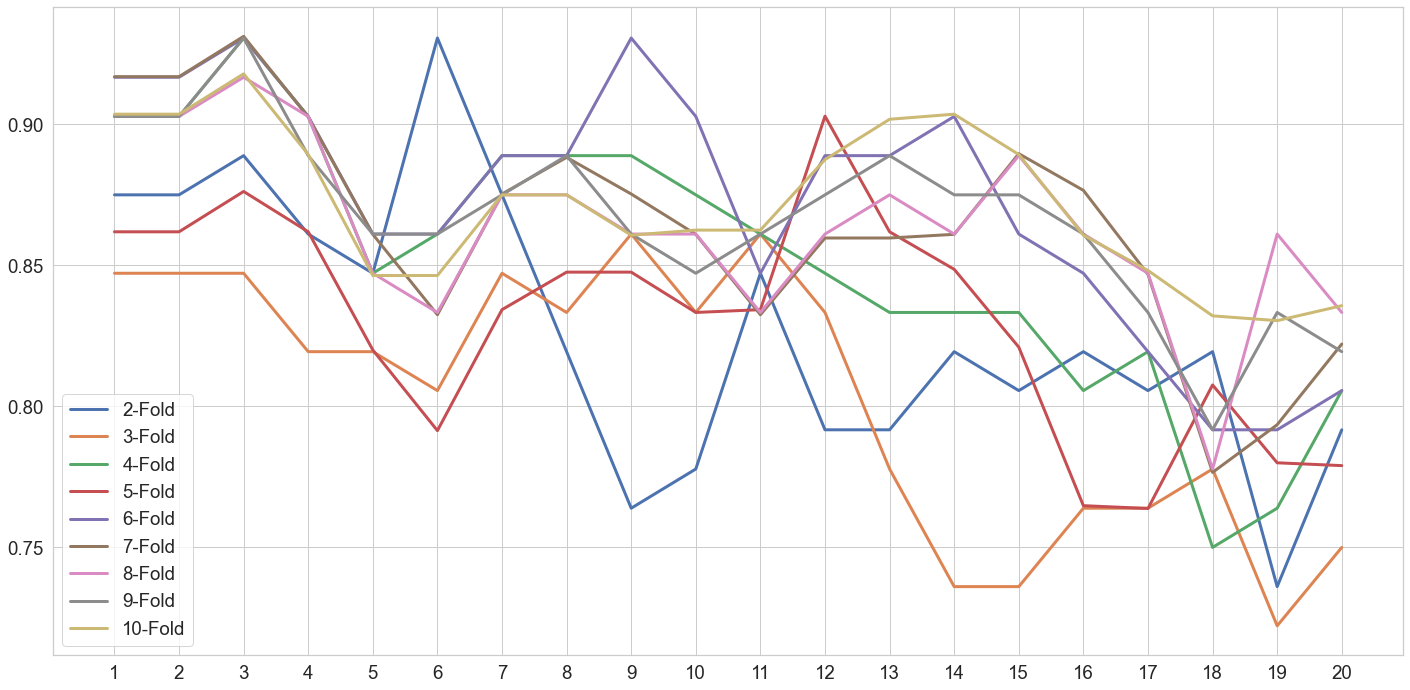

In [303]:
plt.figure(figsize=(20,10))
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=3)
    p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

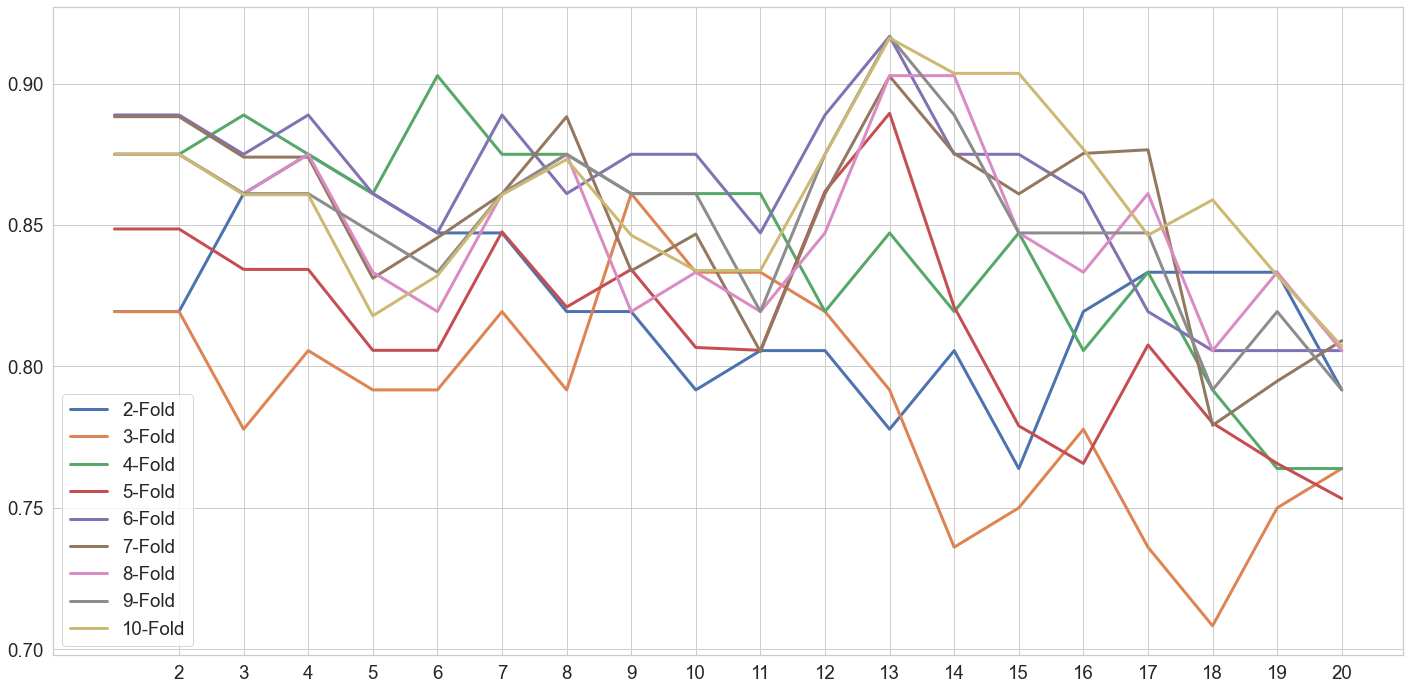

In [304]:
plt.figure(figsize=(20,10))
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='{}-Fold'.format(i+2), linewidth=3)
    p.set_xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [306]:
val_k = []

max_mdl = []
max_akr = []
max_prc = []
max_rcl = []
max_f1 = []
for i in range(9):
    print('FOLD:', i+2, '\t K:', np.argmax(kfld_acc[i])+1, '\t ACC:', np.max(kfld_acc[i]), '\t JUMLAH FITUR:', (np.count_nonzero(pop_pos[np.argmax(pop_acc)])))
    val_k.append(np.argmax(kfld_acc[i])+1)
    max_mdl.append(kfld_mdl[i][np.argmax(kfld_acc[i])])
    max_akr.append(np.max(kfld_acc[i]))
    max_prc.append(kfld_prc[i][np.argmax(kfld_acc[i])])
    max_rcl.append(kfld_rcl[i][np.argmax(kfld_acc[i])])
    max_f1.append(kfld_f1[i][np.argmax(kfld_acc[i])])

FOLD: 2 	 K: 6 	 ACC: 0.9306 	 JUMLAH FITUR: 3730
FOLD: 3 	 K: 9 	 ACC: 0.8611 	 JUMLAH FITUR: 3730
FOLD: 4 	 K: 3 	 ACC: 0.9306 	 JUMLAH FITUR: 3730
FOLD: 5 	 K: 12 	 ACC: 0.9029 	 JUMLAH FITUR: 3730
FOLD: 6 	 K: 3 	 ACC: 0.9306 	 JUMLAH FITUR: 3730
FOLD: 7 	 K: 3 	 ACC: 0.9312 	 JUMLAH FITUR: 3730
FOLD: 8 	 K: 3 	 ACC: 0.9167 	 JUMLAH FITUR: 3730
FOLD: 9 	 K: 3 	 ACC: 0.9306 	 JUMLAH FITUR: 3730
FOLD: 10 	 K: 3 	 ACC: 0.9179 	 JUMLAH FITUR: 3730


In [307]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bpdw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_k, 
              'AkurasiTrain': max_mdl,
              'AkurasiTest': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1_Score': max_f1,
              'Jumlah Fitur':(np.count_nonzero(pop_pos[np.argmax(pop_acc)]))
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

bpdw_df.style.set_table_styles(dfstyle).hide_index()

In [309]:
val_d_k = []

max_d_mdl = []
max_d_akr = []
max_d_prc = []
max_d_rcl = []
max_d_f1 = []
for i in range(9):
    print('FOLD:', i+2, 'K:', np.argmax(kfld_d_acc[i])+1, 'ACC:', np.max(kfld_d_acc[i]))
    val_d_k.append(np.argmax(kfld_d_acc[i])+1)
    max_d_mdl.append(kfld_d_mdl[i][np.argmax(kfld_d_acc[i])])
    max_d_akr.append(np.max(kfld_d_acc[i]))
    max_d_prc.append(kfld_d_prc[i][np.argmax(kfld_d_acc[i])])
    max_d_rcl.append(kfld_d_rcl[i][np.argmax(kfld_d_acc[i])])
    max_d_f1.append(kfld_d_f1[i][np.argmax(kfld_d_acc[i])])

FOLD: 2 K: 4 ACC: 0.875
FOLD: 3 K: 9 ACC: 0.8611
FOLD: 4 K: 6 ACC: 0.9028
FOLD: 5 K: 13 ACC: 0.8895
FOLD: 6 K: 13 ACC: 0.9167
FOLD: 7 K: 13 ACC: 0.9026
FOLD: 8 K: 13 ACC: 0.9028
FOLD: 9 K: 13 ACC: 0.9167
FOLD: 10 K: 13 ACC: 0.9161


In [310]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_d_k, 
              'AkurasiTrain': max_d_mdl,
              'AkurasiTest': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1_Score': max_d_f1,
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

dw_df.style.set_table_styles(dfstyle).hide_index()

### Excel K BPSO-DWKNN

In [311]:
acc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_acc[0],
              'Fold 3': kfld_acc[1],
              'Fold 4': kfld_acc[2],
              'Fold 5': kfld_acc[3],
              'Fold 6': kfld_acc[4],
              'Fold 7': kfld_acc[5],
              'Fold 8': kfld_acc[6],
              'Fold 9': kfld_acc[7],
              'Fold 10': kfld_acc[8],
              })

prc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_prc[0],
              'Fold 3': kfld_prc[1],
              'Fold 4': kfld_prc[2],
              'Fold 5': kfld_prc[3],
              'Fold 6': kfld_prc[4],
              'Fold 7': kfld_prc[5],
              'Fold 8': kfld_prc[6],
              'Fold 9': kfld_prc[7],
              'Fold 10': kfld_prc[8],
              })

rcl_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_rcl[0],
              'Fold 3': kfld_rcl[1],
              'Fold 4': kfld_rcl[2],
              'Fold 5': kfld_rcl[3],
              'Fold 6': kfld_rcl[4],
              'Fold 7': kfld_rcl[5],
              'Fold 8': kfld_rcl[6],
              'Fold 9': kfld_rcl[7],
              'Fold 10': kfld_rcl[8],
              })

f1_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_f1[0],
              'Fold 3': kfld_f1[1],
              'Fold 4': kfld_f1[2],
              'Fold 5': kfld_f1[3],
              'Fold 6': kfld_f1[4],
              'Fold 7': kfld_f1[5],
              'Fold 8': kfld_f1[6],
              'Fold 9': kfld_f1[7],
              'Fold 10': kfld_f1[8],
              })

### Excel K DWKNN

In [312]:
acc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_acc[0],
              'Fold 3': kfld_d_acc[1],
              'Fold 4': kfld_d_acc[2],
              'Fold 5': kfld_d_acc[3],
              'Fold 6': kfld_d_acc[4],
              'Fold 7': kfld_d_acc[5],
              'Fold 8': kfld_d_acc[6],
              'Fold 9': kfld_d_acc[7],
              'Fold 10': kfld_d_acc[8],
              })

prc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_prc[0],
              'Fold 3': kfld_d_prc[1],
              'Fold 4': kfld_d_prc[2],
              'Fold 5': kfld_d_prc[3],
              'Fold 6': kfld_d_prc[4],
              'Fold 7': kfld_d_prc[5],
              'Fold 8': kfld_d_prc[6],
              'Fold 9': kfld_d_prc[7],
              'Fold 10': kfld_d_prc[8],
              })

rcl_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_rcl[0],
              'Fold 3': kfld_d_rcl[1],
              'Fold 4': kfld_d_rcl[2],
              'Fold 5': kfld_d_rcl[3],
              'Fold 6': kfld_d_rcl[4],
              'Fold 7': kfld_d_rcl[5],
              'Fold 8': kfld_d_rcl[6],
              'Fold 9': kfld_d_rcl[7],
              'Fold 10': kfld_d_rcl[8],
              })

f1_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_f1[0],
              'Fold 3': kfld_d_f1[1],
              'Fold 4': kfld_d_f1[2],
              'Fold 5': kfld_d_f1[3],
              'Fold 6': kfld_d_f1[4],
              'Fold 7': kfld_d_f1[5],
              'Fold 8': kfld_d_f1[6],
              'Fold 9': kfld_d_f1[7],
              'Fold 10': kfld_d_f1[8],
              })

## BPSO-DWKNN Plot

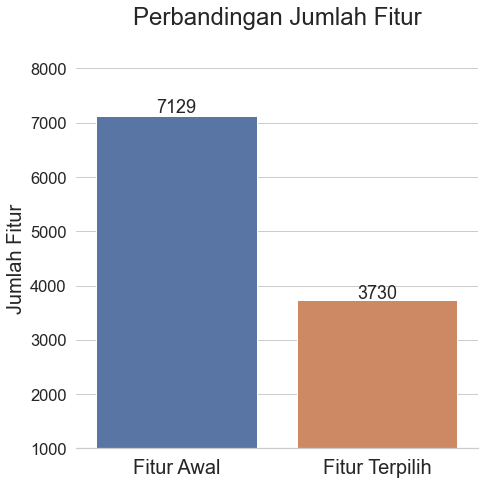

In [313]:
ax_y = [X.shape[1], np.count_nonzero(pop_pos[np.argmax(pop_acc)])]
ax_x = ['Fitur Awal', 'Fitur Terpilih']
plt.figure(figsize=(7,7))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.barplot(x=ax_x, y=ax_y)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Fitur', fontsize=24, y=1.1)
p.set_ylabel("Jumlah Fitur", fontsize = 20)
p.set_xticklabels(ax_x, fontsize = 20)
p.set_ylim(1000, 8000)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Jumlah Fitur.png')

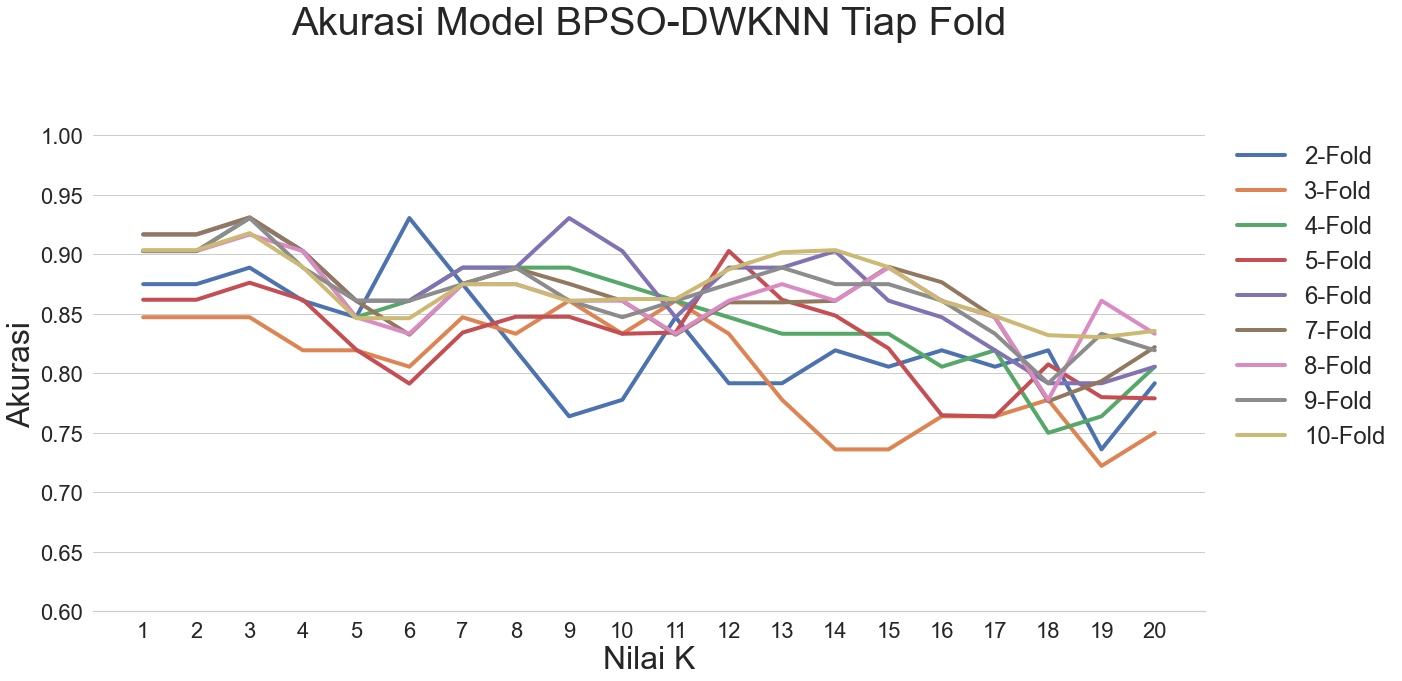

In [314]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
p.set_title('Akurasi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Akurasi BPSO-DW Tiap Fold.png')

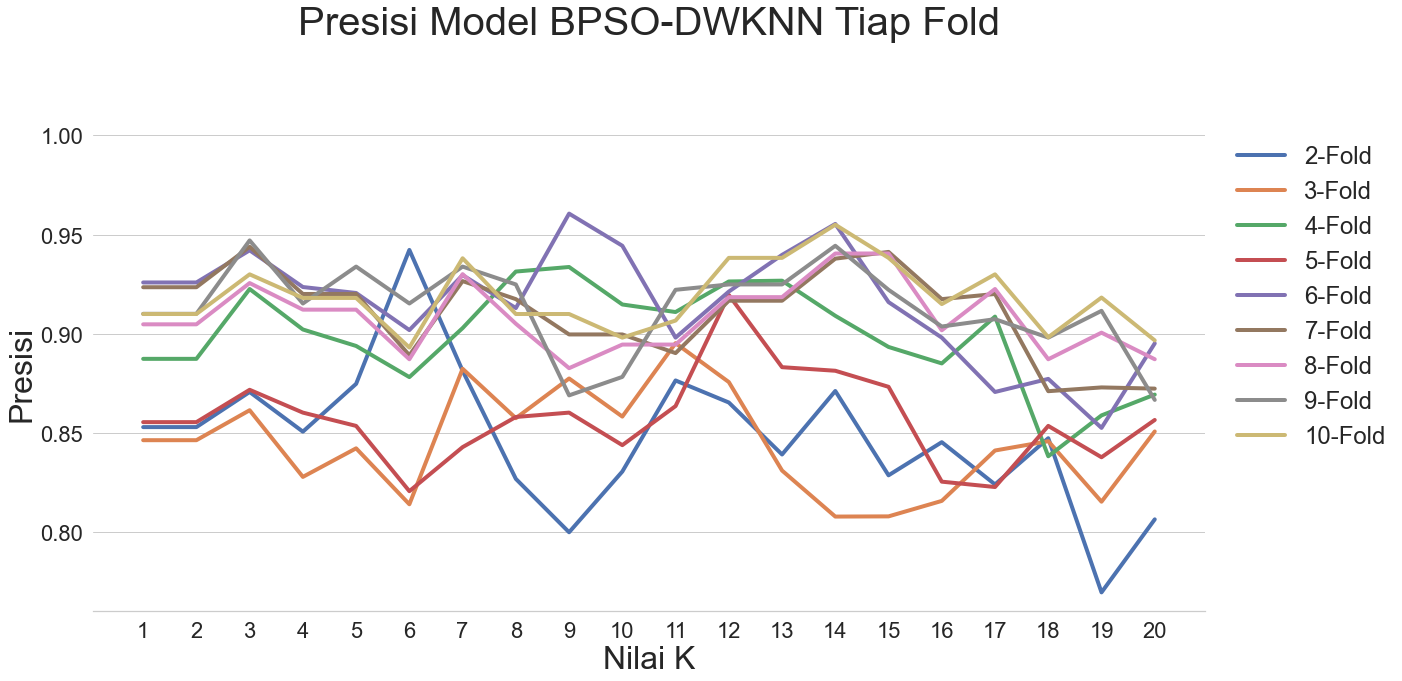

In [315]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Presisi BPSO-DW Tiap Fold.png')

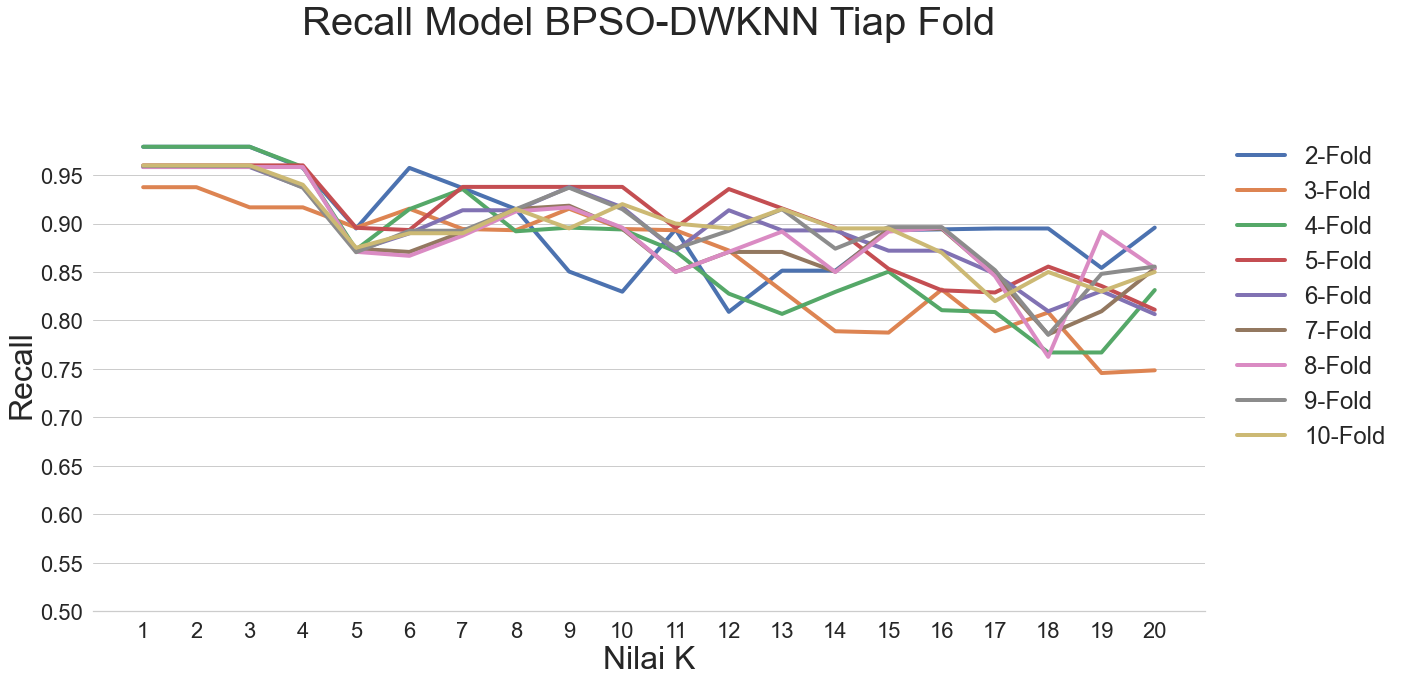

In [316]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Recall BPSO-DW Tiap Fold.png')

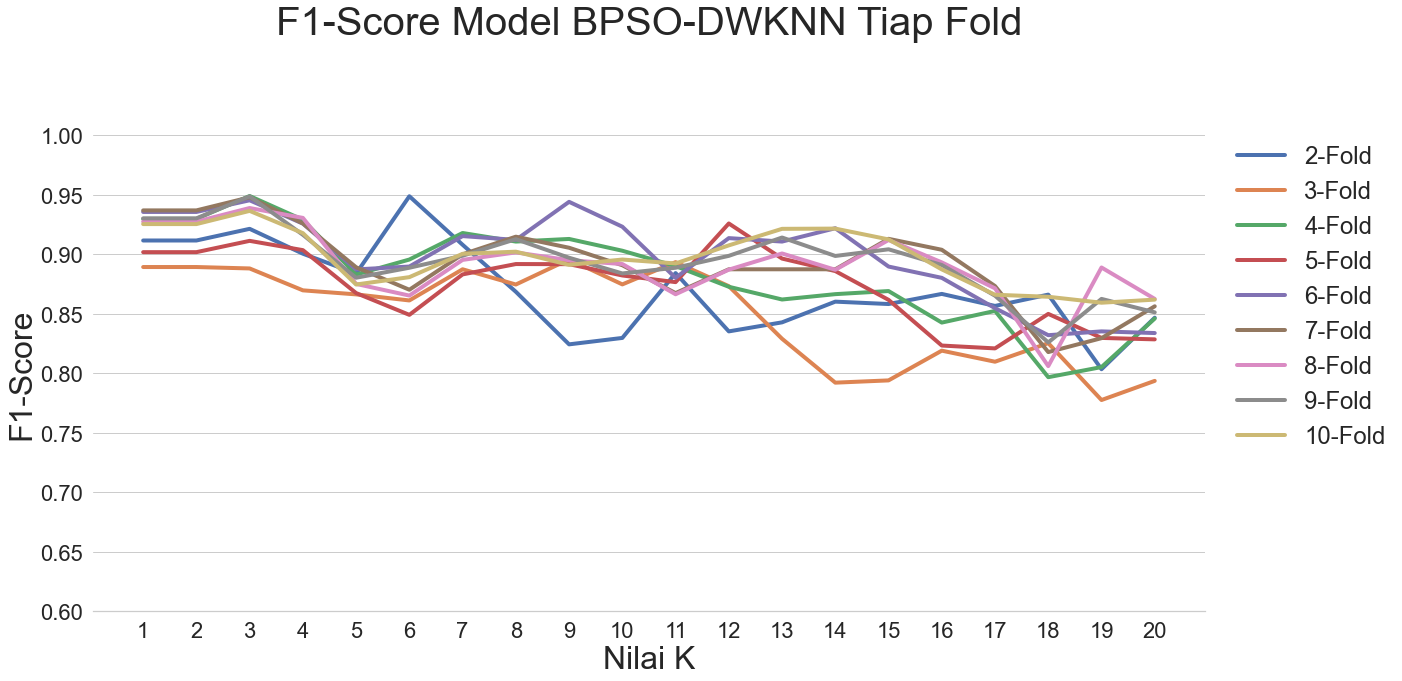

In [317]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/F1-Score BPSO-DW Tiap Fold.png')

In [318]:
kfld_acc[5][2]

0.9312

Confusion matrix, without normalization


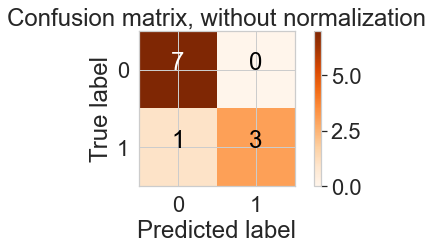

Confusion matrix, without normalization


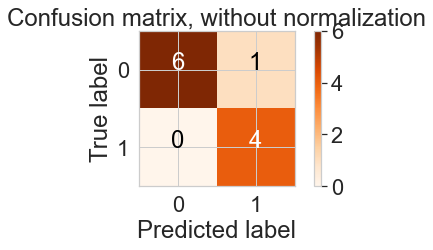

Confusion matrix, without normalization


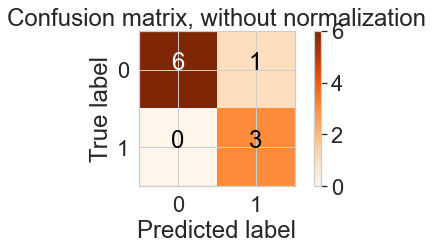

Confusion matrix, without normalization


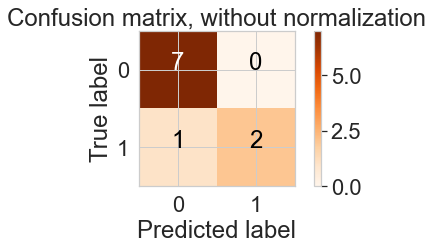

Confusion matrix, without normalization


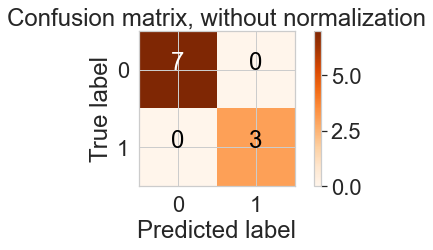

Confusion matrix, without normalization


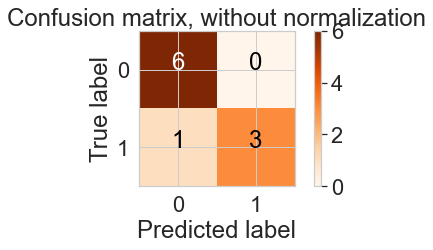

Confusion matrix, without normalization


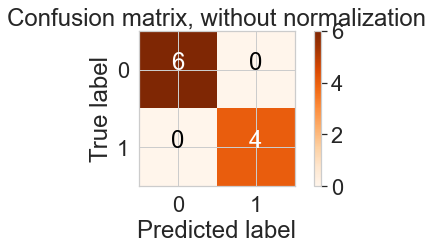

In [319]:
for i in range(7):
    plot_confusion_matrix(kfld_pred[5][2][i], kfld_act[5][2][i])

## DWKNN Plot

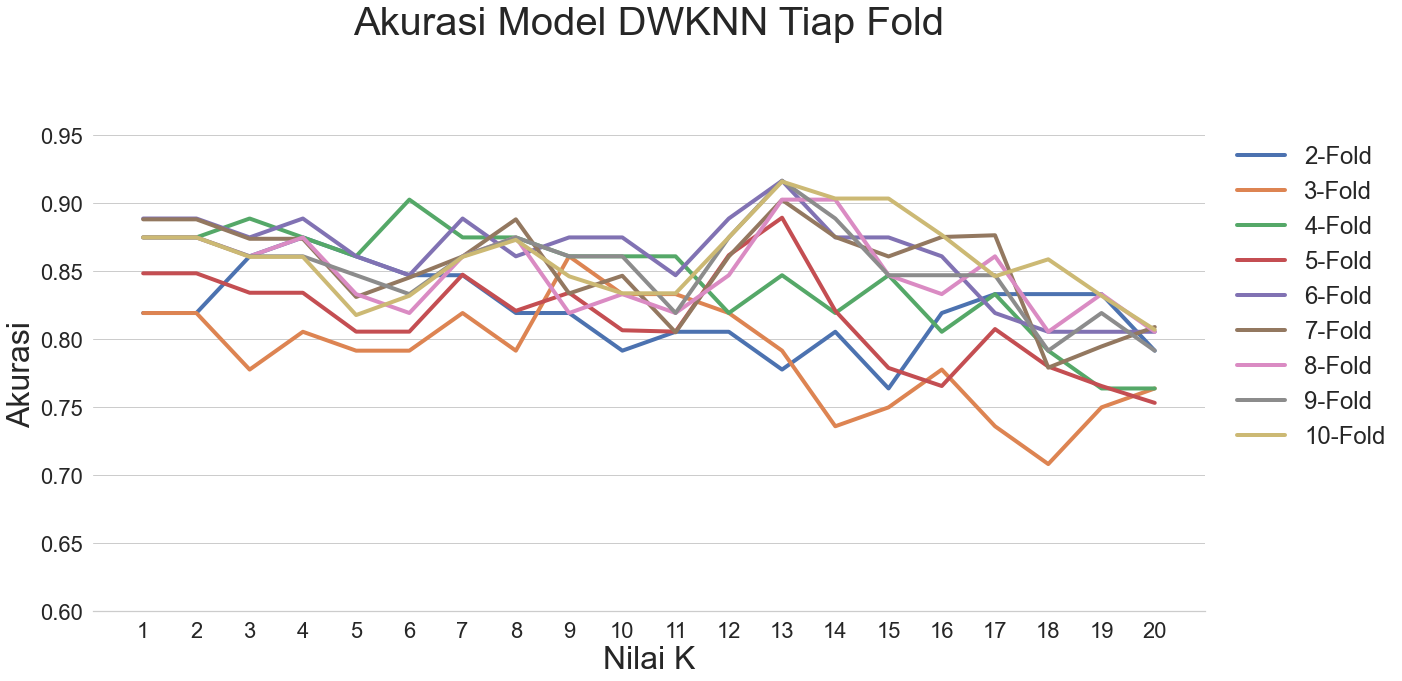

In [320]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Akurasi Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Akurasi DW Tiap Fold.png')

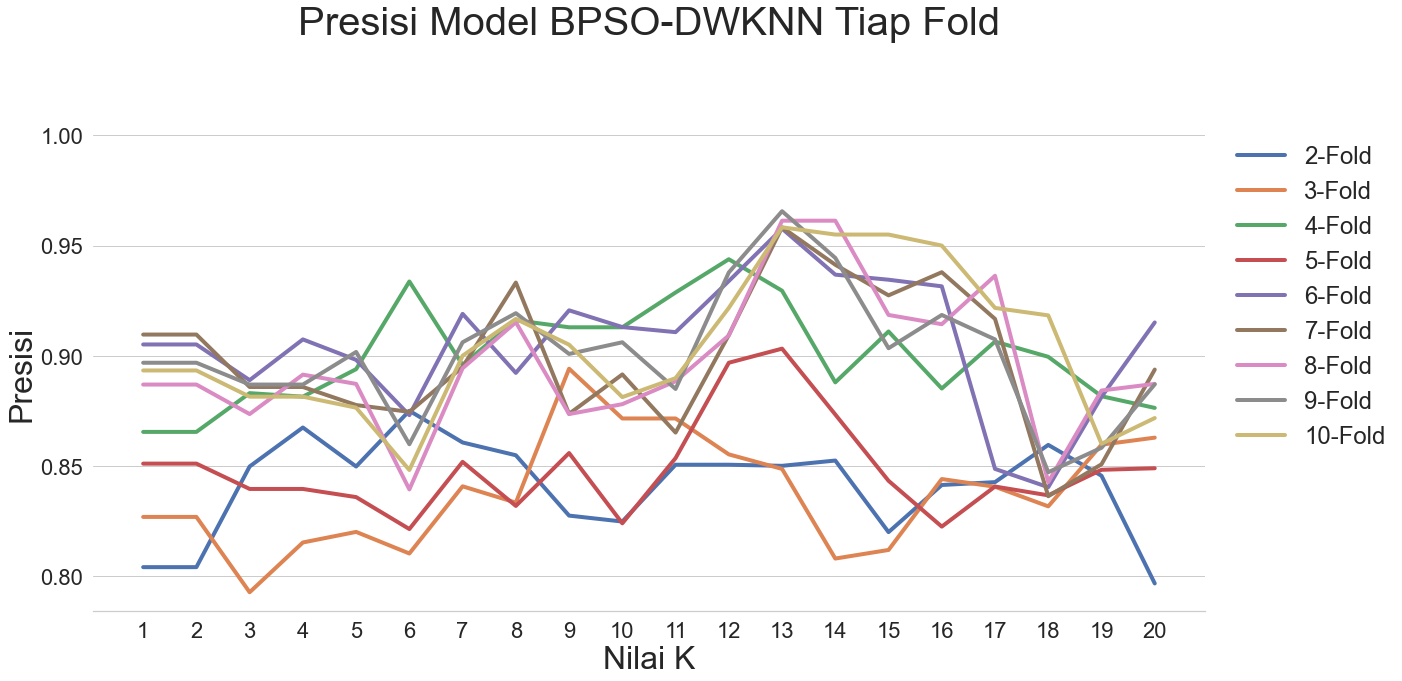

In [321]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Presisi DW Tiap Fold.png')

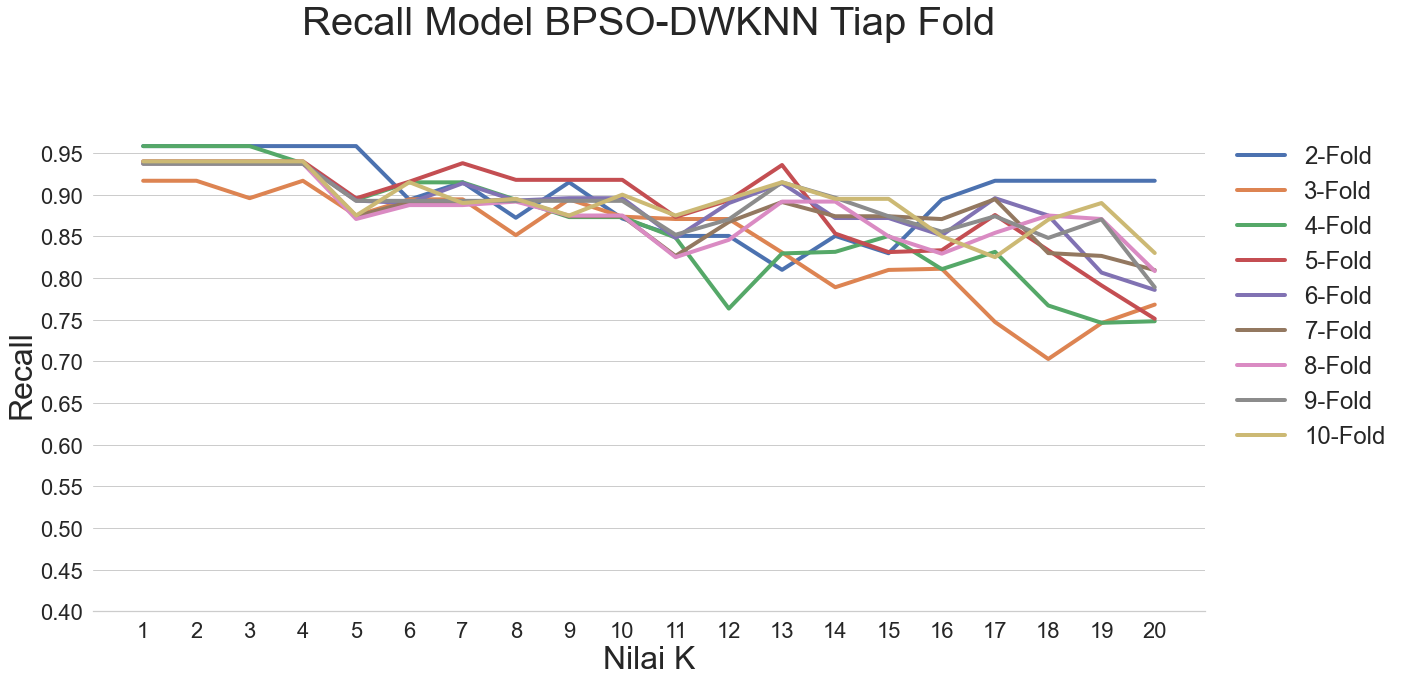

In [322]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Recall DW Tiap Fold.png')

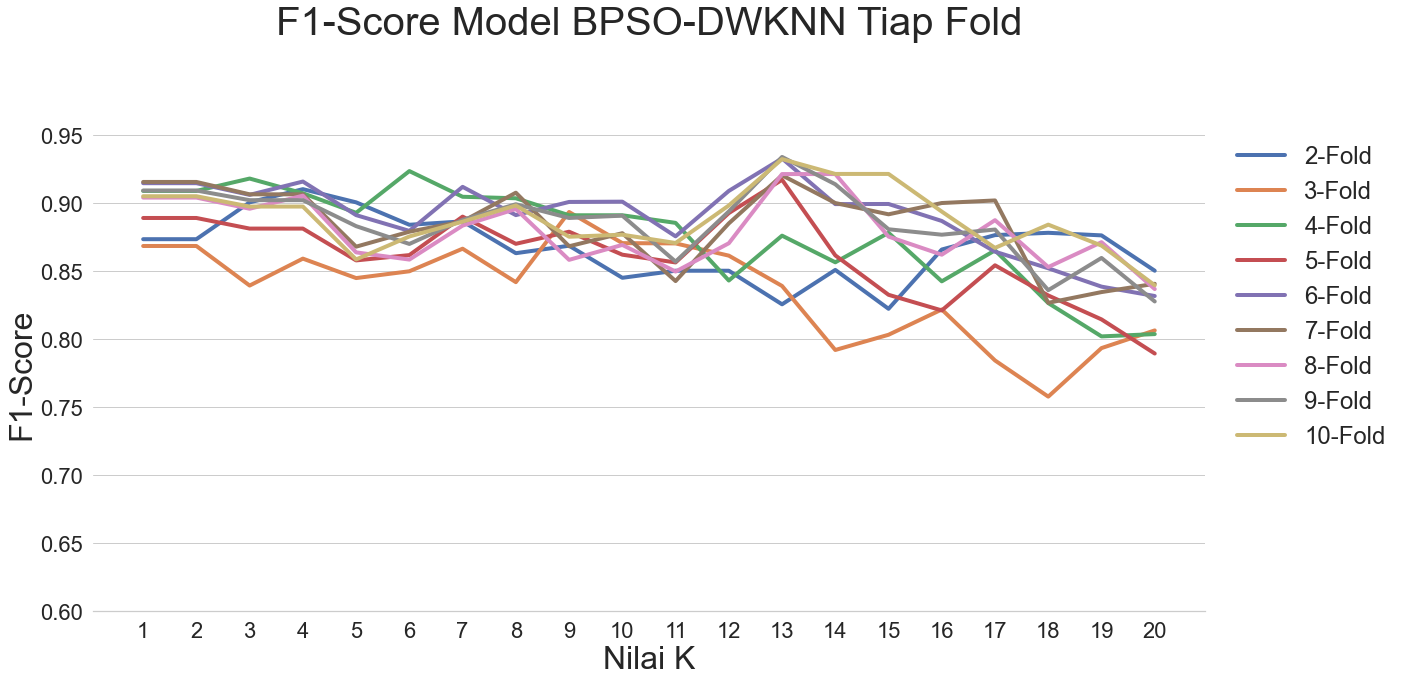

In [323]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([ 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/F1-Score DW Tiap Fold.png')

In [324]:
kfld_d_acc[7][12]

0.9167

Confusion matrix, without normalization


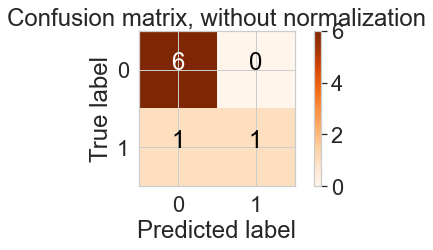

Confusion matrix, without normalization


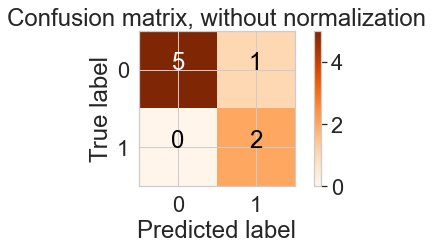

Confusion matrix, without normalization


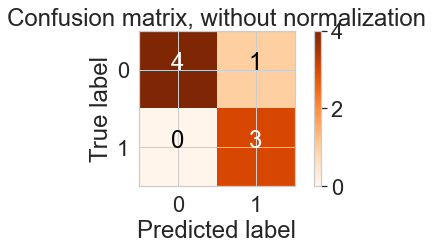

Confusion matrix, without normalization


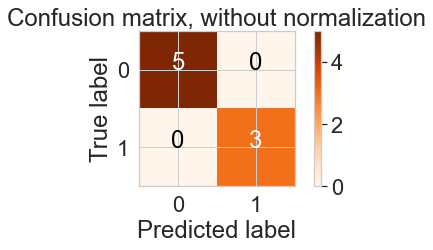

Confusion matrix, without normalization


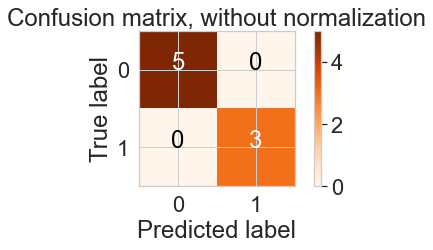

Confusion matrix, without normalization


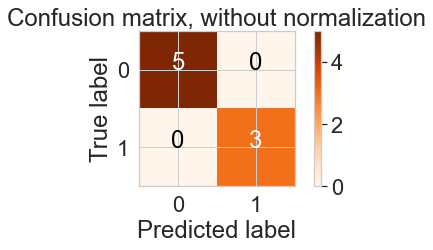

Confusion matrix, without normalization


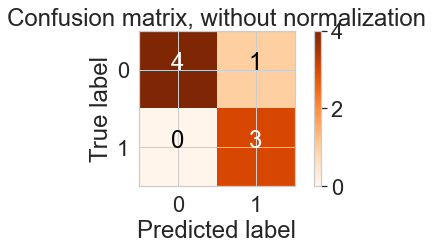

Confusion matrix, without normalization


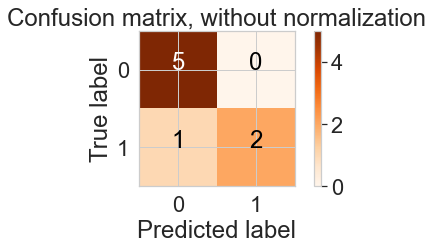

Confusion matrix, without normalization


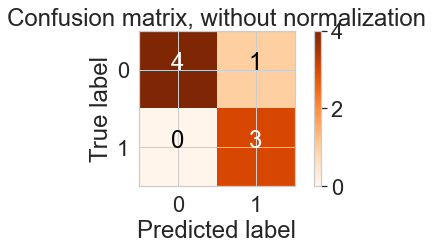

In [325]:
for i in range(9):
    plot_confusion_matrix(kfld_d_pred[7][12][i], kfld_d_act[7][12][i])

## BPSO-DWKNN vs DWKNN

In [326]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hsl01_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_k, 
              'Akurasi': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1-Score': max_f1,
              'Model': 'BPSO-DWKNN',
              })
hsl02_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_d_k, 
              'Akurasi': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1-Score': max_d_f1,
              'Model': 'DWKNN',
              })
hsl03_df = hsl01_df.append(hsl02_df)

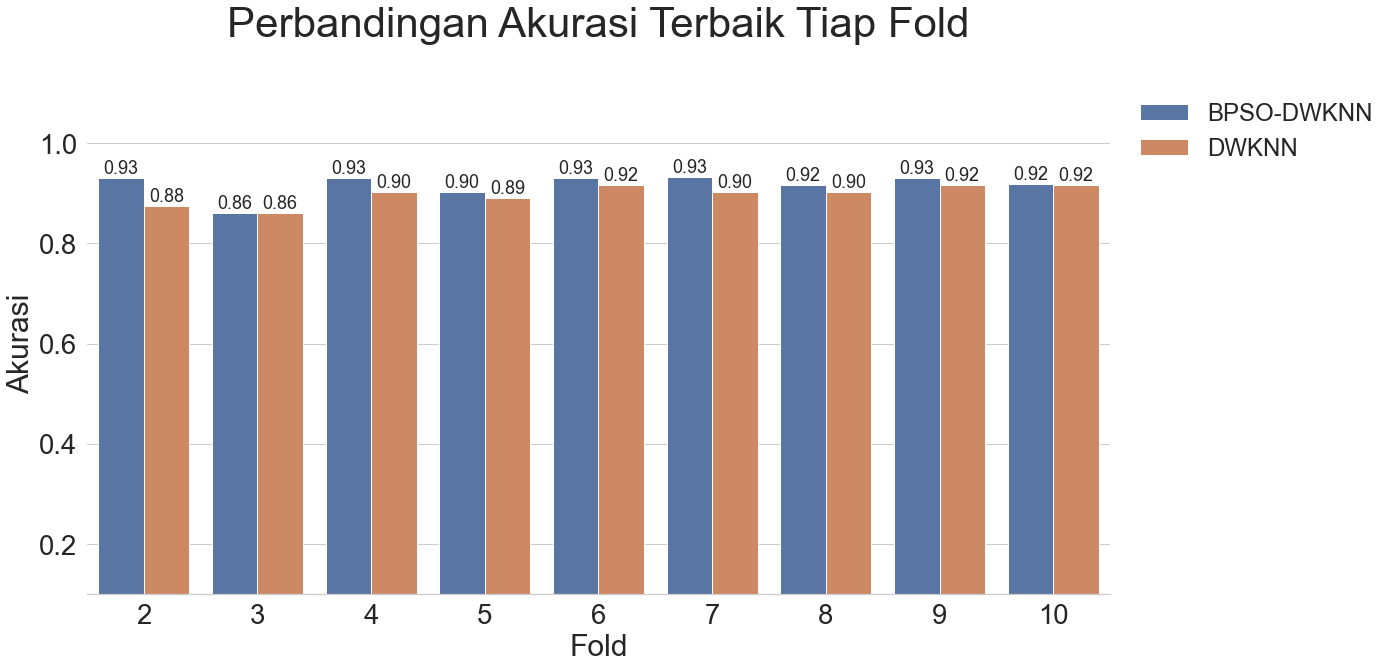

In [327]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Akurasi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Perbandingan Akurasi Terbaik Tiap Fold.png')

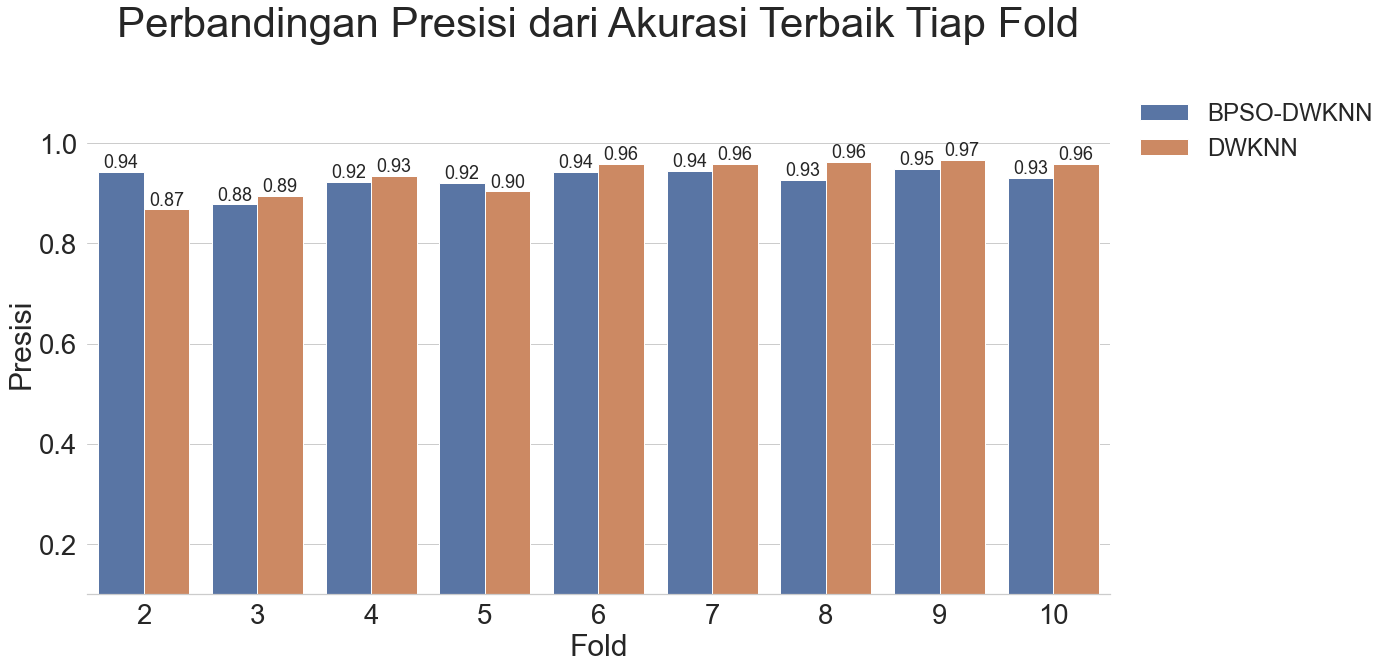

In [328]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Presisi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Presisi dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Perbandingan Presisi dari Akurasi Terbaik Tiap Fold.png')

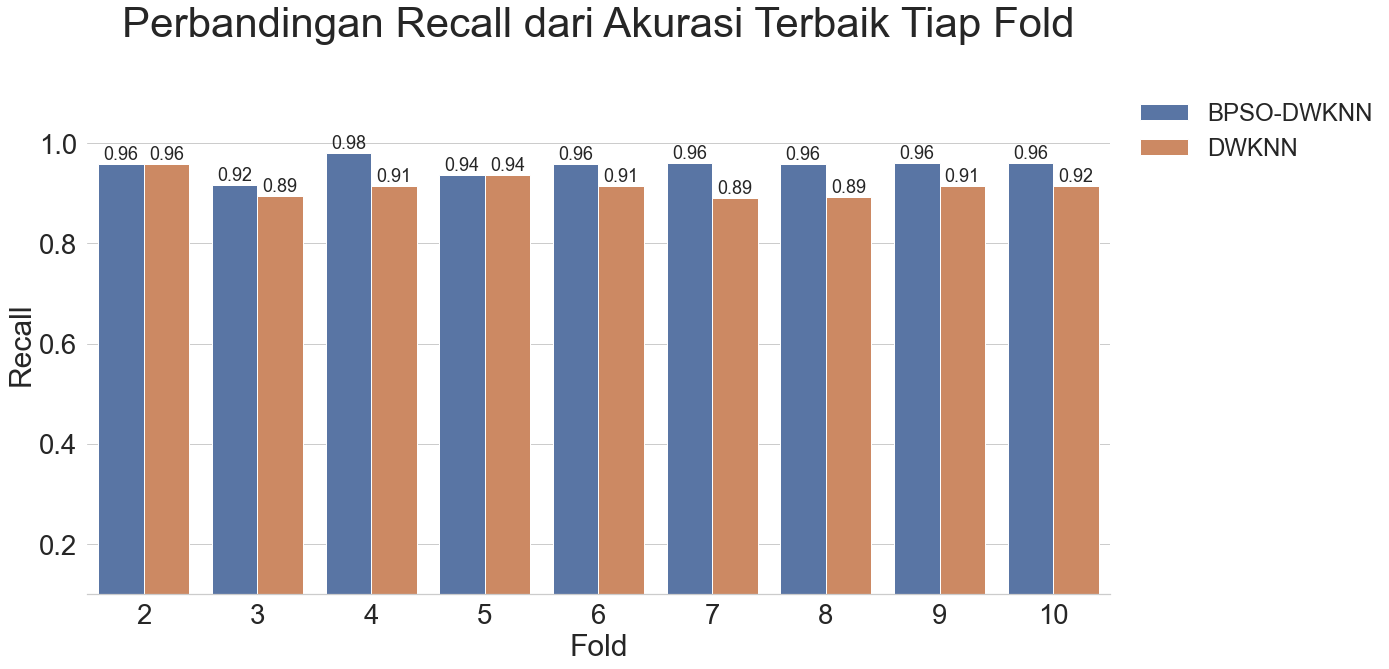

In [329]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Recall', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Recall dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Perbandingan Recall dari Akurasi Terbaik Tiap Fold.png')

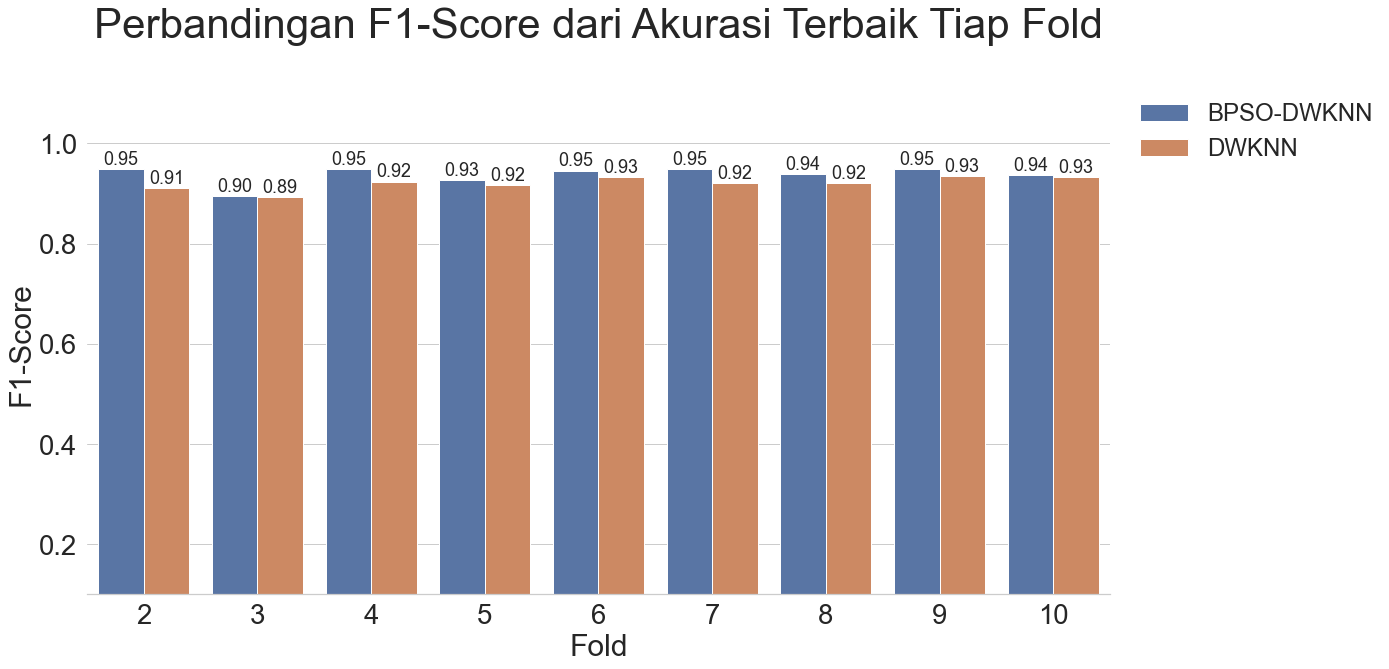

In [330]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='F1-Score', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold.png')

In [331]:
dw_df.values[7][0]

9.0

In [332]:
max_all_df = pd.DataFrame({'Matriks':['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'Akurasi', 'Presisi', 'Recall', 'F1-Score'],
                        'Nilai':[np.max(bpdw_df.AkurasiTest.values), 
                                 bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)],                        
                                 bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 dw_df.values[7][3], 
                                 dw_df.values[7][4], 
                                 dw_df.values[7][5],
                                 dw_df.values[7][6]],
                        'Model':['BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'DWKNN', 'DWKNN', 'DWKNN', 'DWKNN'],
                      })

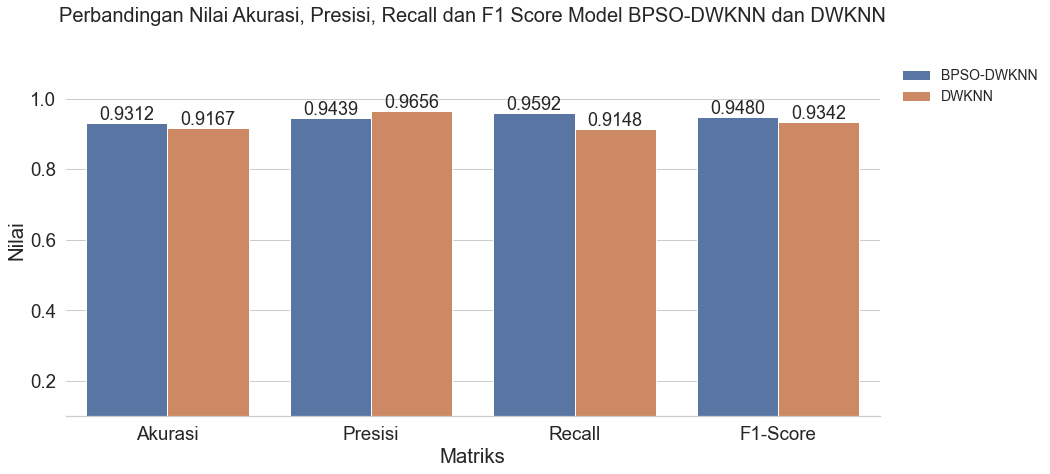

In [333]:
plt.figure(figsize=(15, 7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
p = sns.barplot(x='Matriks', y='Nilai', hue='Model', data=max_all_df)
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14, frameon=False)
p.set_title('Perbandingan Nilai Akurasi, Presisi, Recall dan F1 Score Model BPSO-DWKNN dan DWKNN', fontsize=20, y=1.1)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/ConfusionMatrix BPSO-DW Vs DW.png')

## DataFrame to Excel

In [122]:
max_v = max(kfld_acc[8])
idx = []
for i in range(len(kfld_acc[8])):
    if max_v == kfld_acc[8][i]:
        idx.append(i)
        print(kfld_acc[8][i])
print(idx)

0.9714
0.9714
0.9714
[0, 1, 3]


In [126]:
max_d_v = max(kfld_d_acc[8])
idx_d = []
for i in range(len(kfld_d_acc[8])):
    if max_d_v == kfld_d_acc[8][i]:
        idx_d.append(i)
        print(kfld_d_acc[8][i])
print(idx_d)

0.9446
[2]


In [334]:
result_df = pd.DataFrame({'Model': ['BPSO-DWKNN', 'DWKNN'],
                      'Fold': [bpdw_df.Fold[np.argmax(bpdw_df.AkurasiTest)], dw_df.values[7][0]],
                      'Nilai K': [bpdw_df.Nilai_K[np.argmax(bpdw_df.AkurasiTest)], dw_df.values[7][1]],
                      'Akurasi Train': [np.max(bpdw_df.AkurasiTrain.values), dw_df.values[7][2]],
                      'Akurasi Test': [np.max(bpdw_df.AkurasiTest.values), dw_df.values[7][3]],
                      'Presisi': [bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.values[7][4]],
                      'Recall': [bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.values[7][5]],
                      'F1-Score': [bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.values[7][6]],
                      'Jumlah Fitur': [np.count_nonzero(pop_pos[np.argmax(pop_acc)]), X.shape[1]],
                      })

C:\Anaconda\envs\jcopml\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [335]:
result_df

Model  Fold  Nilai K  Akurasi Train  Akurasi Test  Presisi  Recall  \
0  BPSO-DWKNN   7.0      3.0            1.0        0.9312   0.9439  0.9592   
1       DWKNN   9.0     13.0            1.0        0.9167   0.9656  0.9148   

   F1-Score  Jumlah Fitur  
0    0.9480          3730  
1    0.9342          7129

In [349]:
fold_fs_df.name = "Percobaan Fold Pada Seleksi Fitur"
w0_df.name = "W = 0.9"
w1_df.name = "W = 0.1"
pop_df.name = "Percobaan Populasi"
result_df.name = "Hasil Akurasi"
bpdw_df.name = "Akurasi Terbaik BPSO-DWKNN tiap Fold"
dw_df.name = "Akurasi Terbaik DWKNN tiap Fold"

acc_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

acc_d_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_d_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_d_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_d_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

writer = pd.ExcelWriter('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia.xlsx',engine='xlsxwriter')
workbook=writer.book

# Formating
merge_format = workbook.add_format({
    'bold': 1,
    'border': None,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#fc8f30',
    'font_color': 'white'})

cell_format = workbook.add_format({
    'bg_color': '#ffdea1'})

border_fmt = workbook.add_format({
    'bottom':3, 
    'top':3, 
    'left':3, 
    'right':3})


# Excel Fold
worksheet=workbook.add_worksheet('Fold')
writer.sheets['Fold'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(fold_fs_df)+1, len(fold_fs_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', fold_fs_df.name, merge_format)
# to_xlsx
fold_fs_df.to_excel(writer,sheet_name='Fold',startrow=1 , startcol=0, index=None)

#Excel Parameter PSO
worksheet=workbook.add_worksheet('BPSOPar')
writer.sheets['BPSOPar'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(w0_df)+1, len(w0_df.columns)), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(2, 0, 6, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:F1', w0_df.name, merge_format)
# to_xlsx
w0_df.to_excel(writer,sheet_name='BPSOPar',startrow=1 , startcol=0)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 15, 5), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 10, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(11, 0, 15, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A10:F10', w1_df.name, merge_format)
# to_xlsx
w1_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + 5, startcol=0)
# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 23, 6), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 19, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A19:G19', pop_df.name, merge_format)
# to_xlsx
pop_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + w1_df.shape[0] + 9, startcol=0, index=None)

# Excel Tabel Akurasi Terbaik BPSO-DW Tiap Fold
worksheet=workbook.add_worksheet('BPSO-DWKNN')
writer.sheets['BPSO-DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(bpdw_df)+1, len(bpdw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 7), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:H1', bpdw_df.name, merge_format)
# to_xlsx
bpdw_df.to_excel(writer,sheet_name='BPSO-DWKNN',startrow=1 , startcol=0, index=None)

# Excel Tabel Akurasi Terbaik DW Tiap Fold
worksheet=workbook.add_worksheet('DWKNN')
writer.sheets['DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(dw_df)+1, len(dw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', dw_df.name, merge_format)
# to_xlsx
dw_df.to_excel(writer,sheet_name='DWKNN',startrow=1 , startcol=0, index=None)

#Excel Hasil Akhir
worksheet=workbook.add_worksheet('Hasil Akurasi')
writer.sheets['Hasil Akurasi'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(result_df)+1, len(result_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 8), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:I1', result_df.name, merge_format)
# to xlsx
result_df.to_excel(writer,sheet_name='Hasil Akurasi',startrow=1 , startcol=0, index=None)

#Excel Acc, prc, rcl, f1 BPSO DW perFold
worksheet=workbook.add_worksheet('BPSO-DW Acc, Prc, Rcl, F1')
writer.sheets['BPSO-DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_bpdw_k_df)+1, len(acc_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_bpdw_k_df.name, merge_format)
# to xlsx
acc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_bpdw_k_df.name, merge_format)
# to_xlsx
prc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_bpdw_k_df.name, merge_format)
# to_xlsx
f1_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 5 + rcl_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

#Excel Acc, prc, rcl, f1 DW perFold
worksheet=workbook.add_worksheet('DW Acc, Prc, Rcl, F1')
writer.sheets['DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_d_bpdw_k_df)+1, len(acc_d_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_d_bpdw_k_df.name, merge_format)
# to xlsx
acc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_d_bpdw_k_df.name, merge_format)
# to_xlsx
prc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_d_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_d_bpdw_k_df.name, merge_format)
# to_xlsx
f1_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 5 + rcl_d_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

writer.save()

## Plot Per Fold

### BPSO-DWKNN

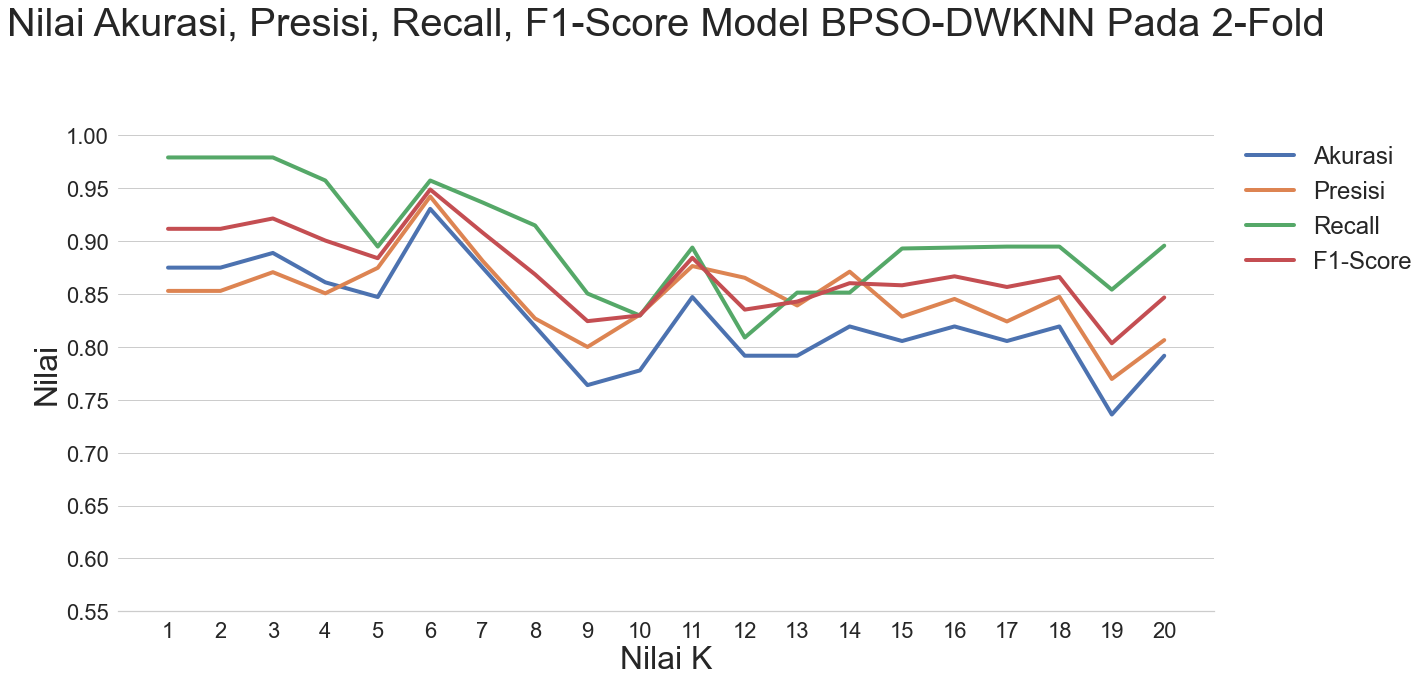

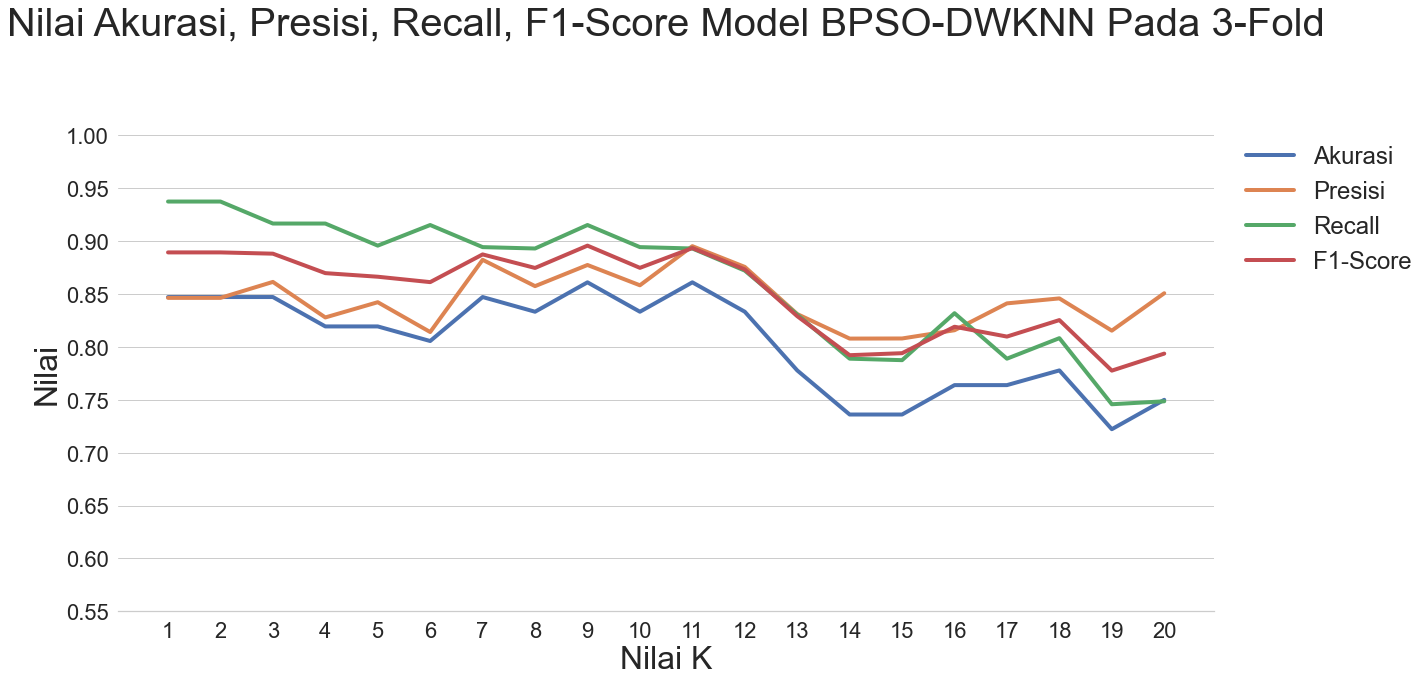

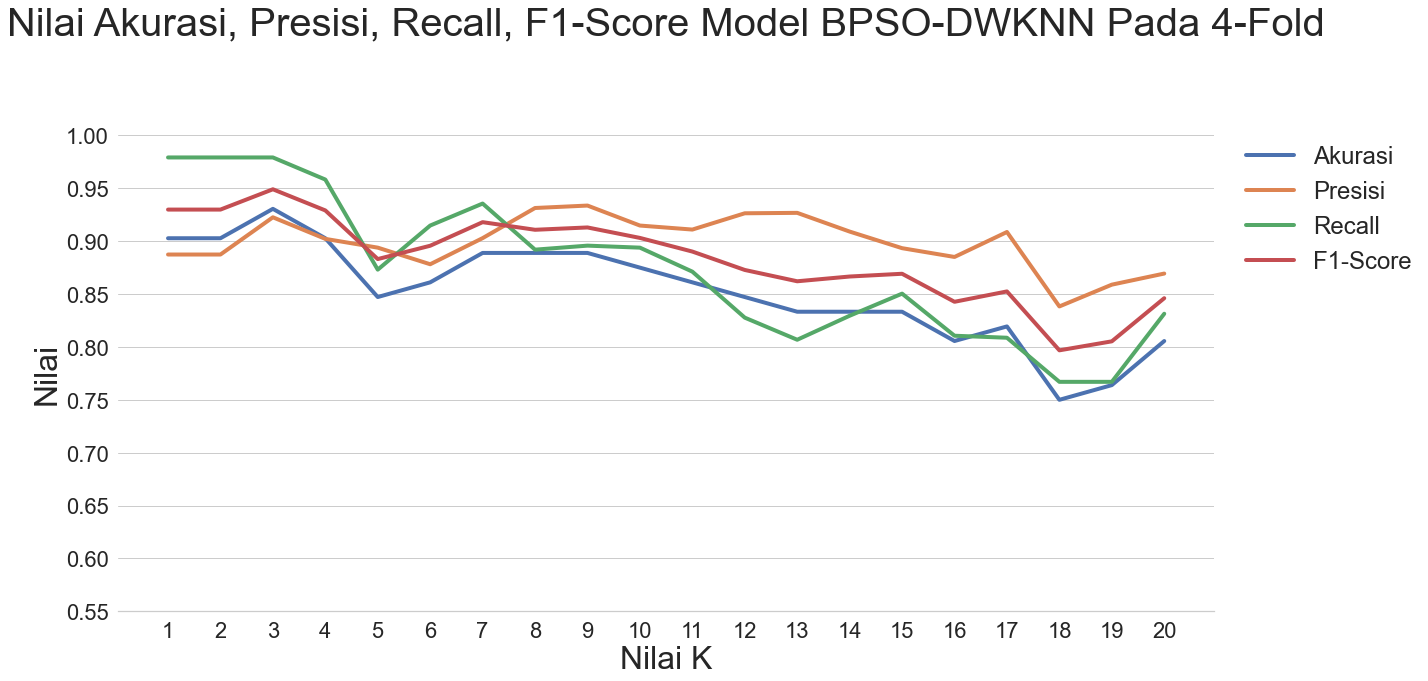

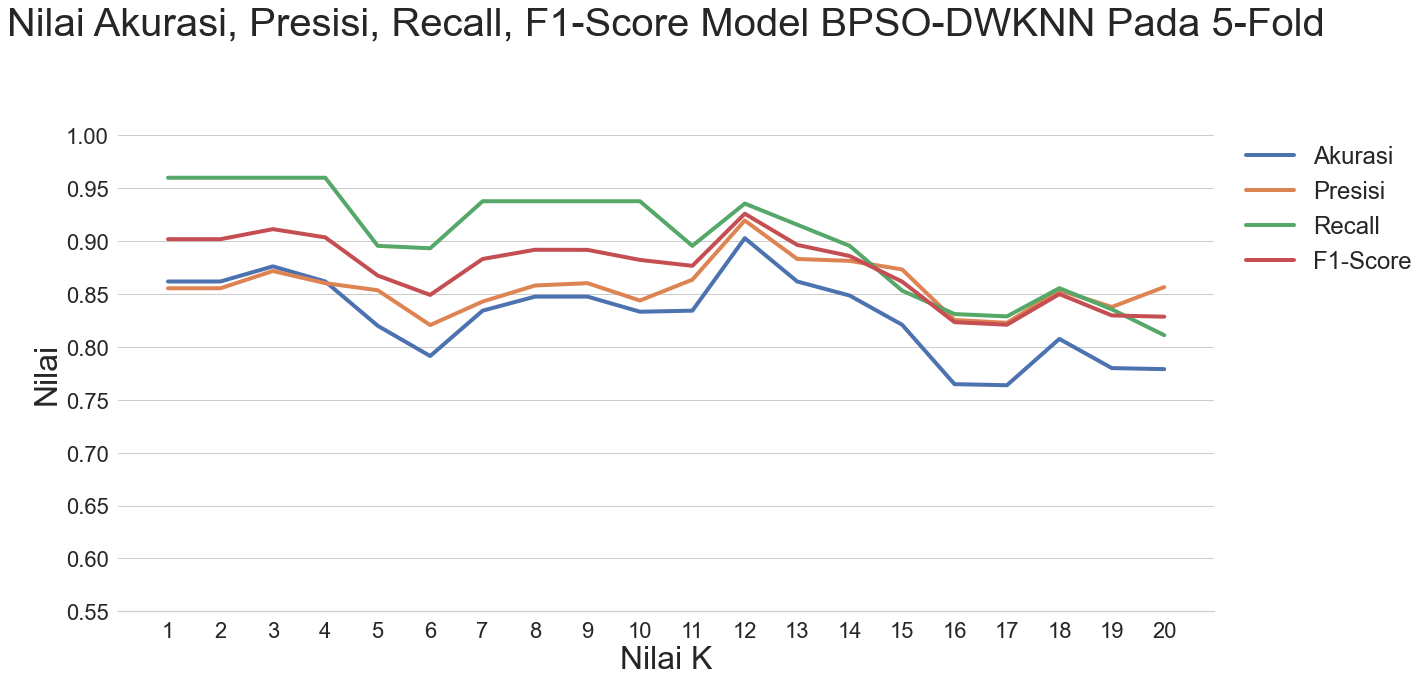

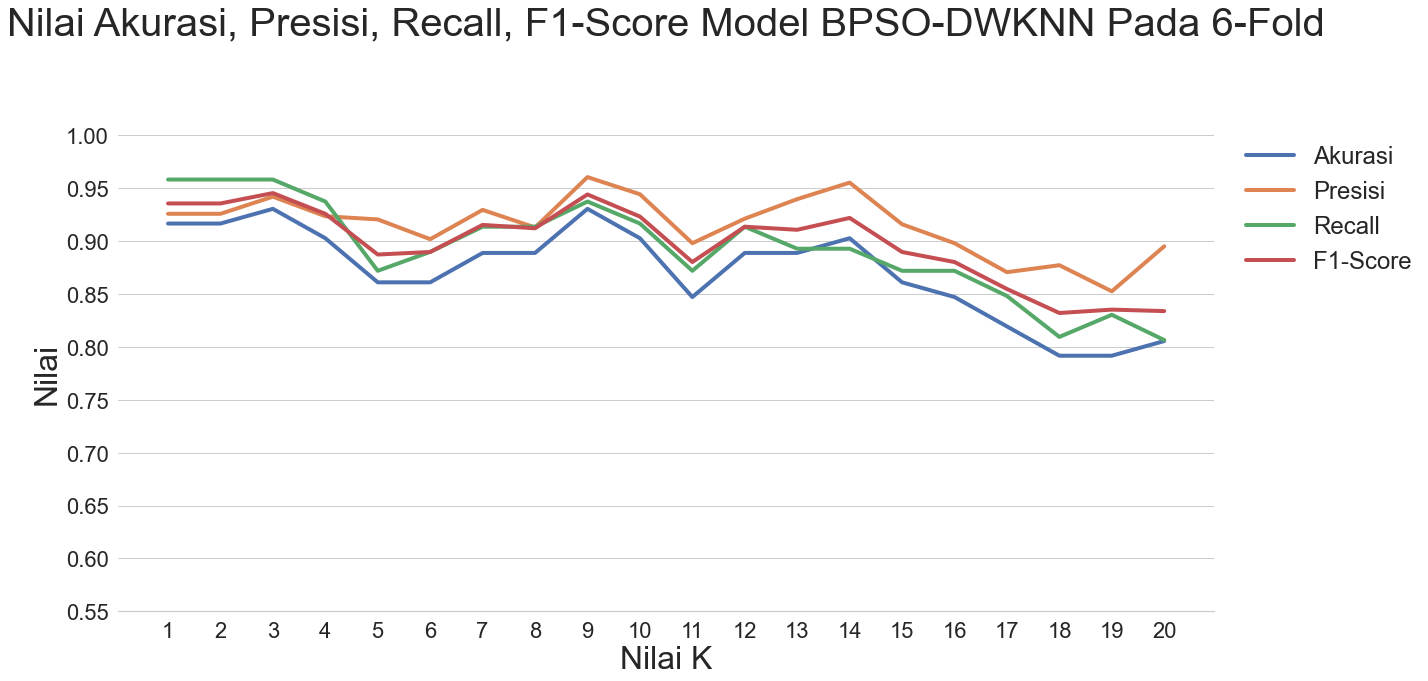

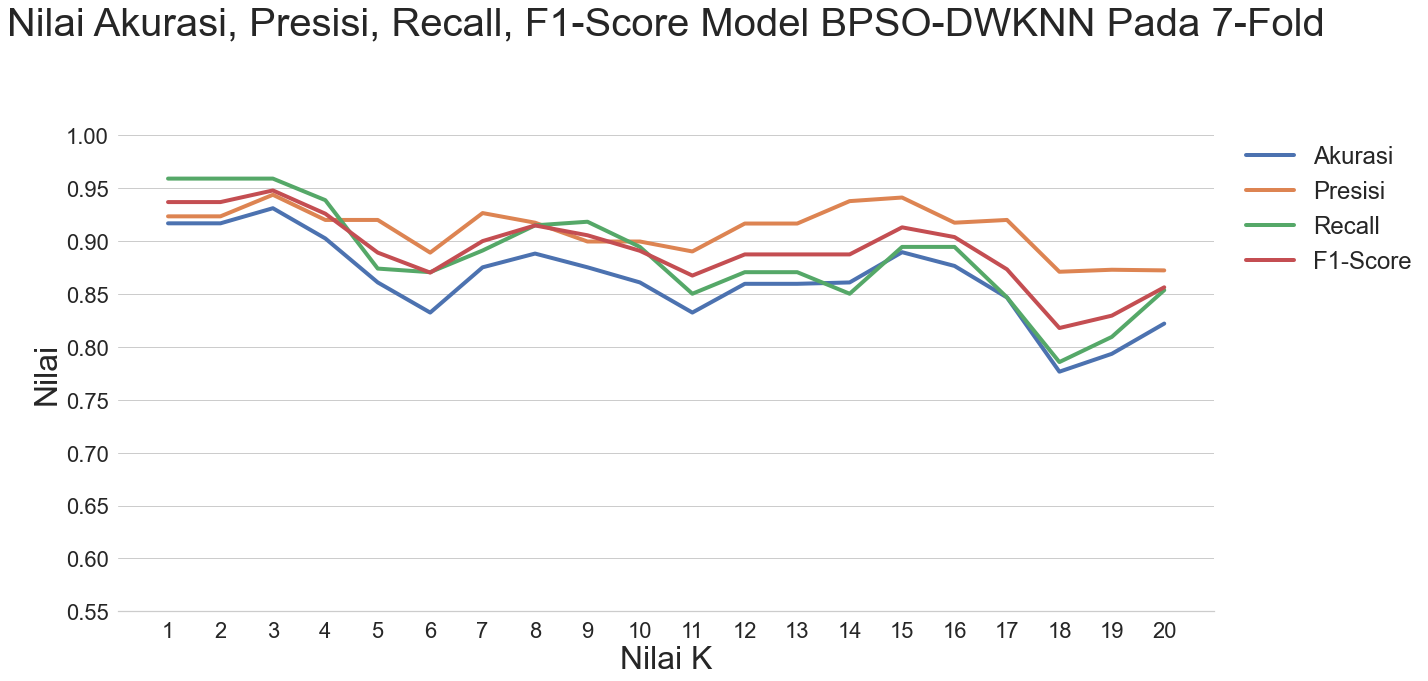

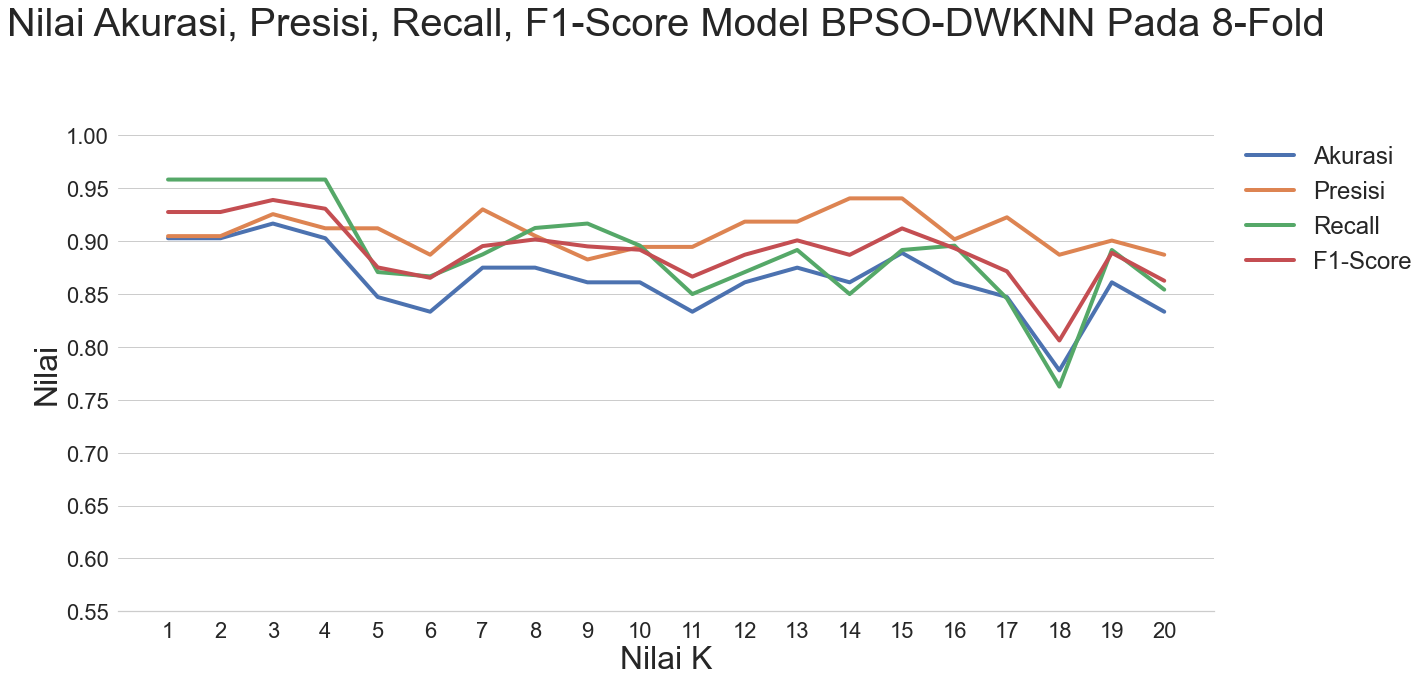

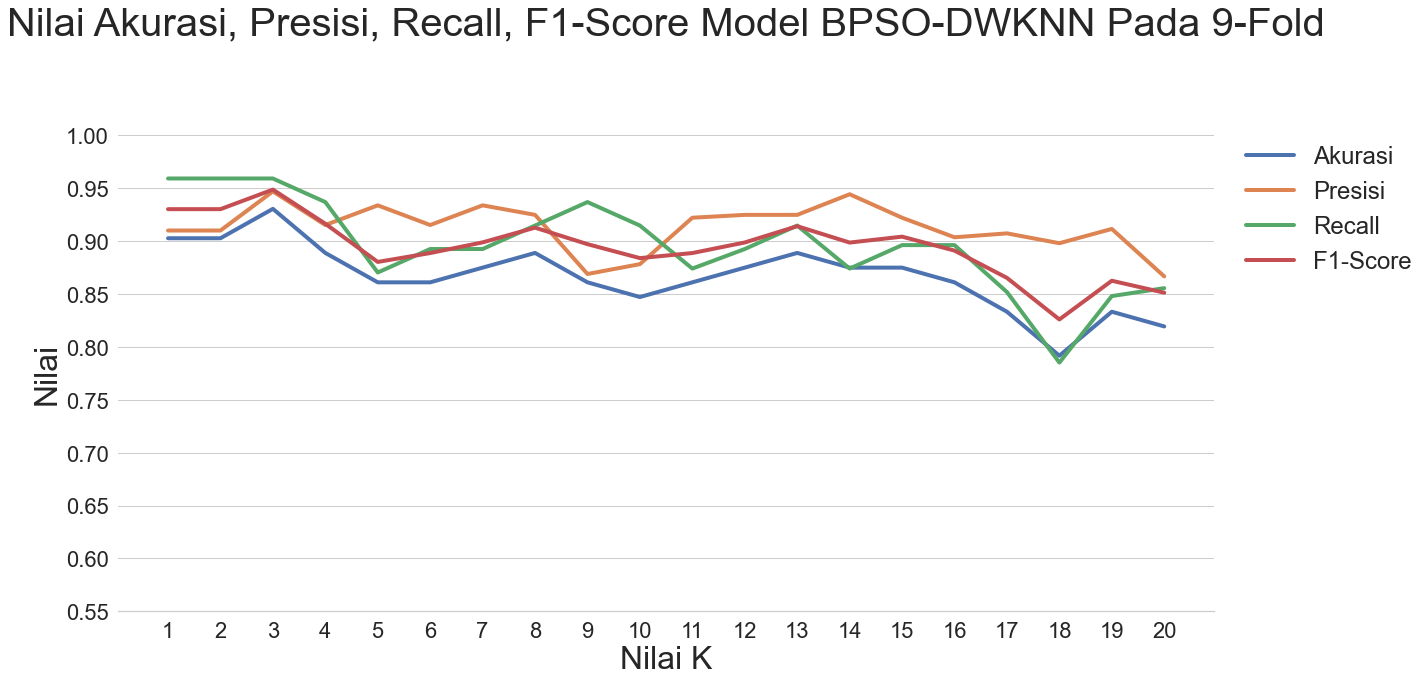

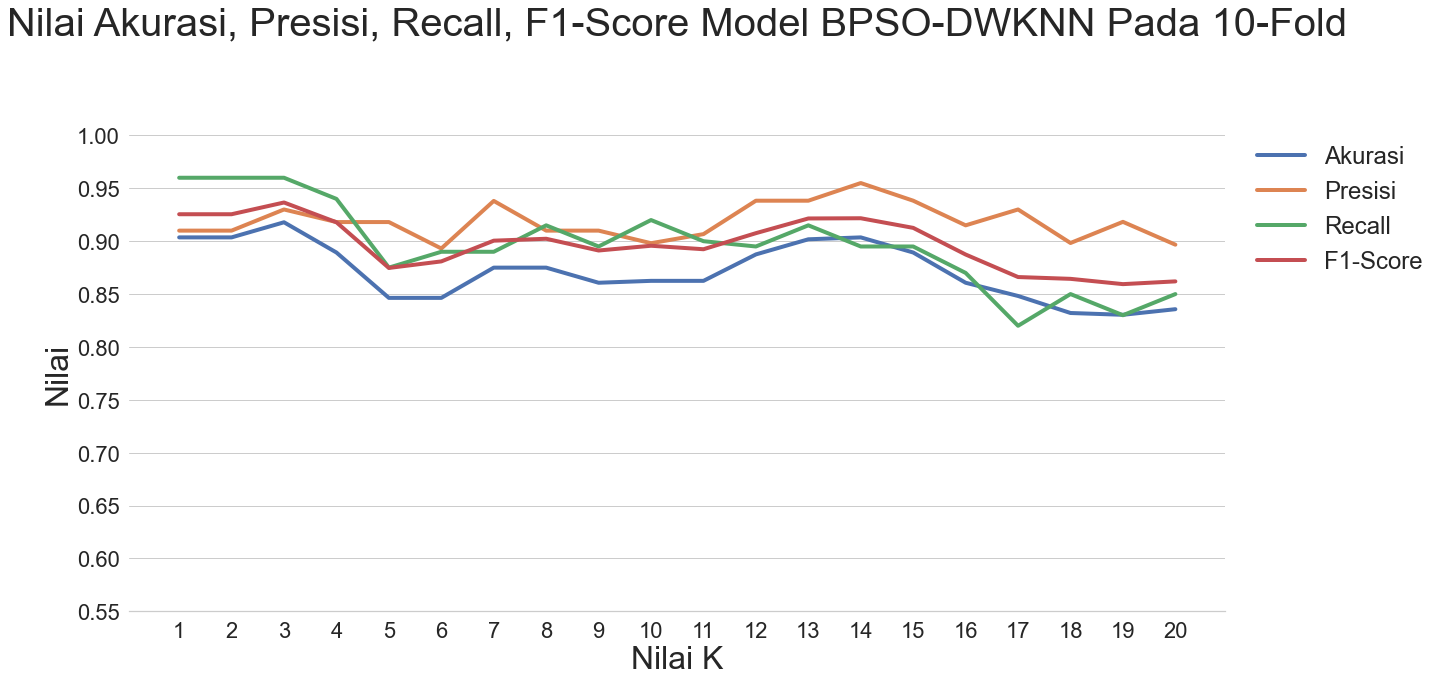

In [337]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model BPSO-DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/BPSO-DW Per Fold/BPSO-DW {}-Fold.png'.format(i+2))

### DWKNN

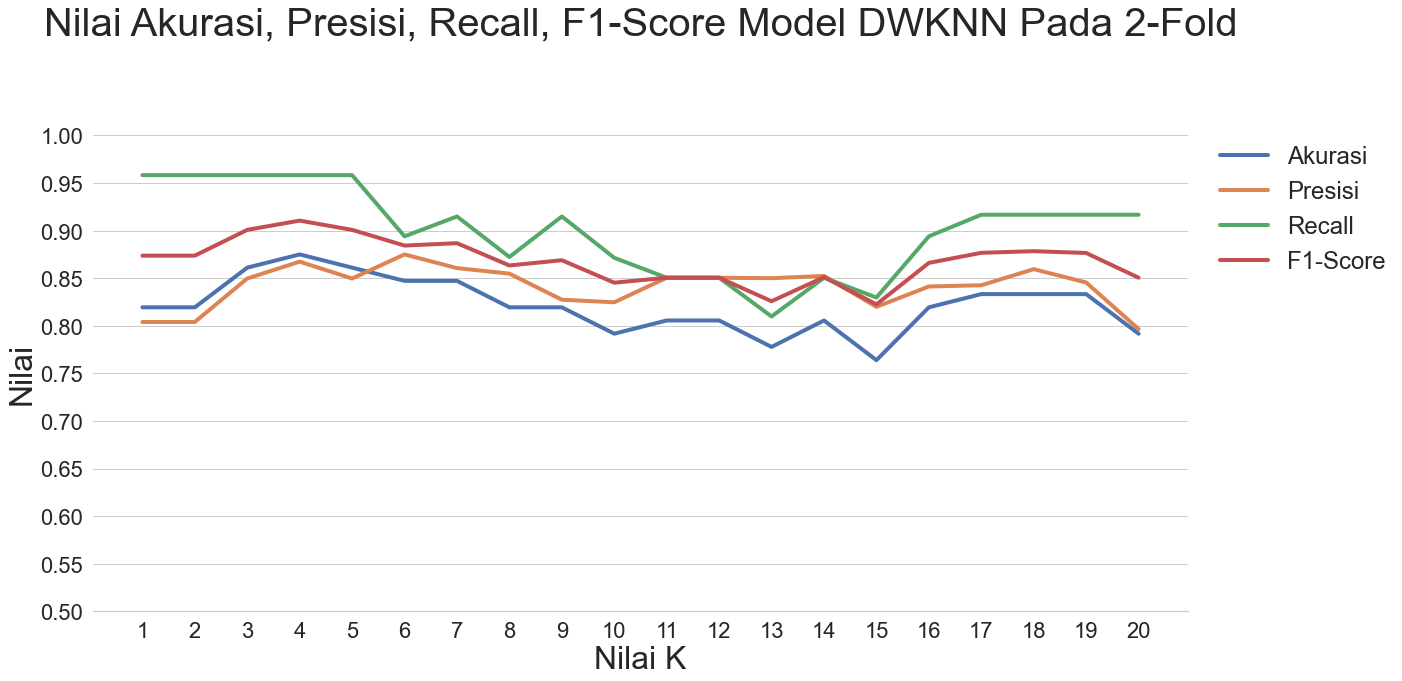

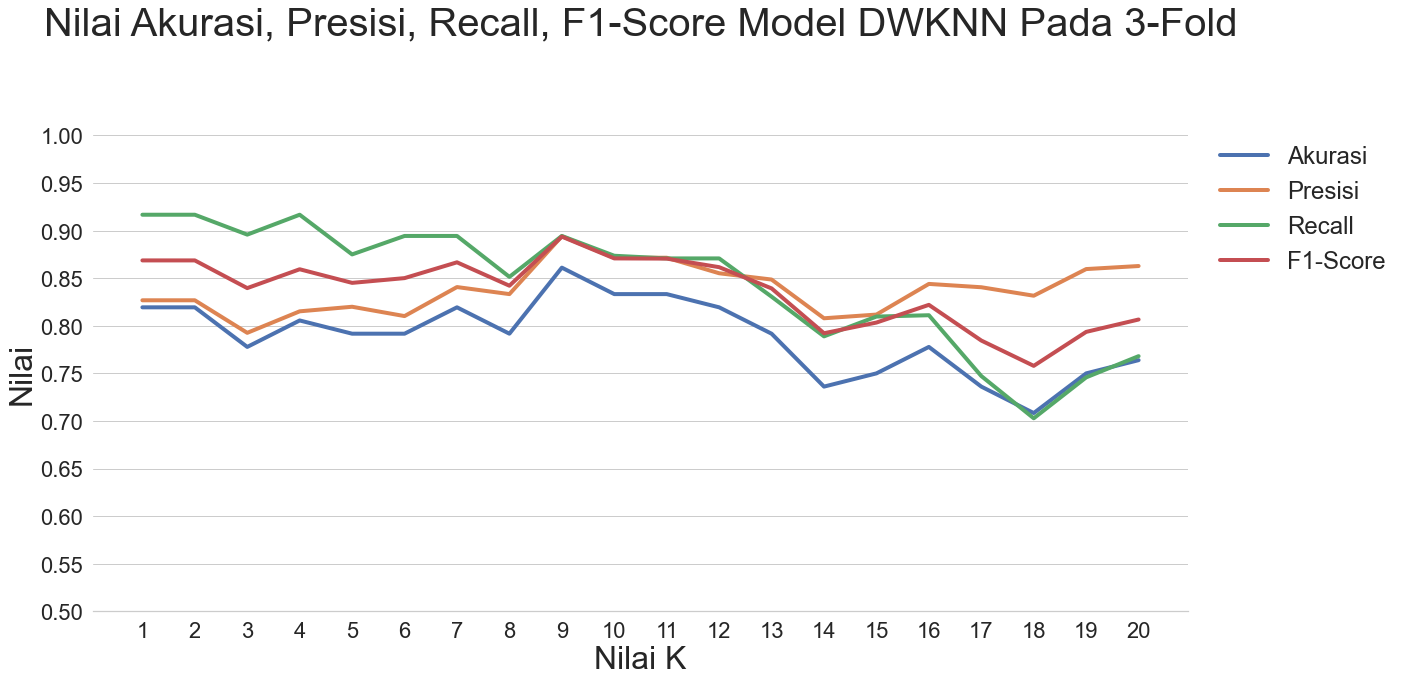

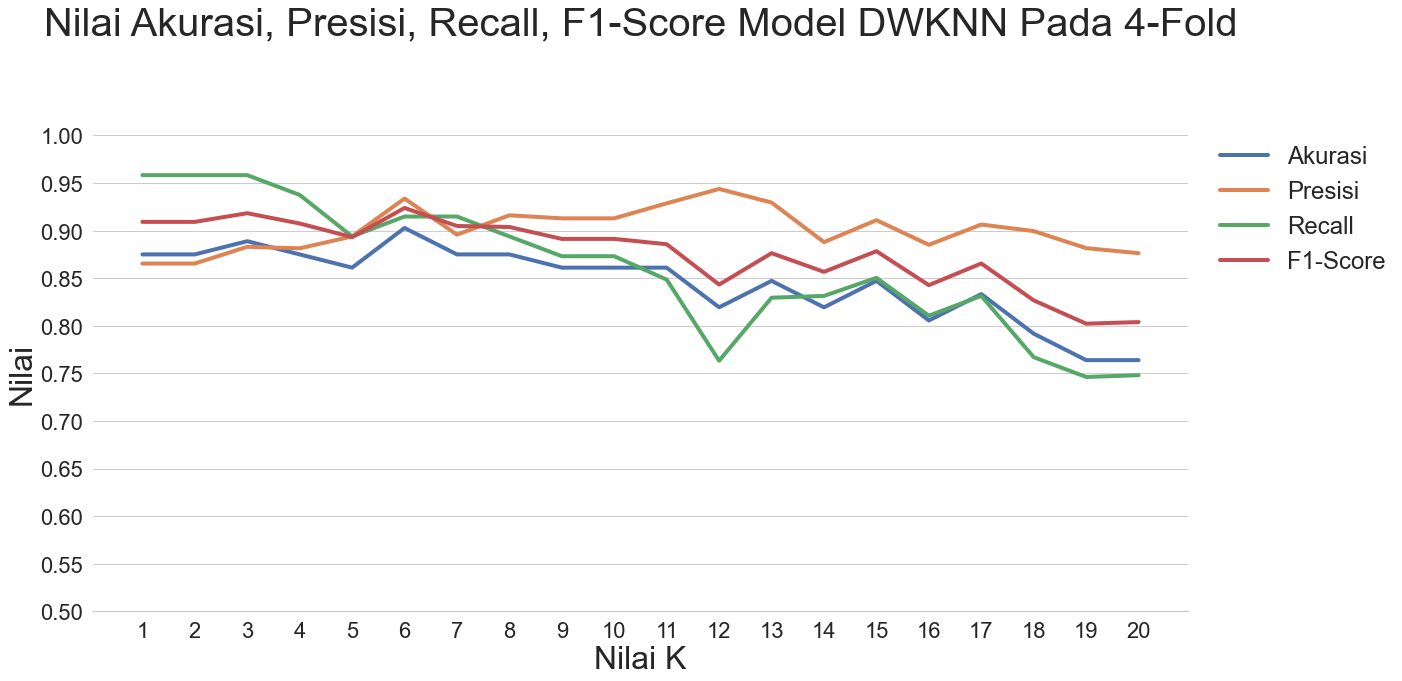

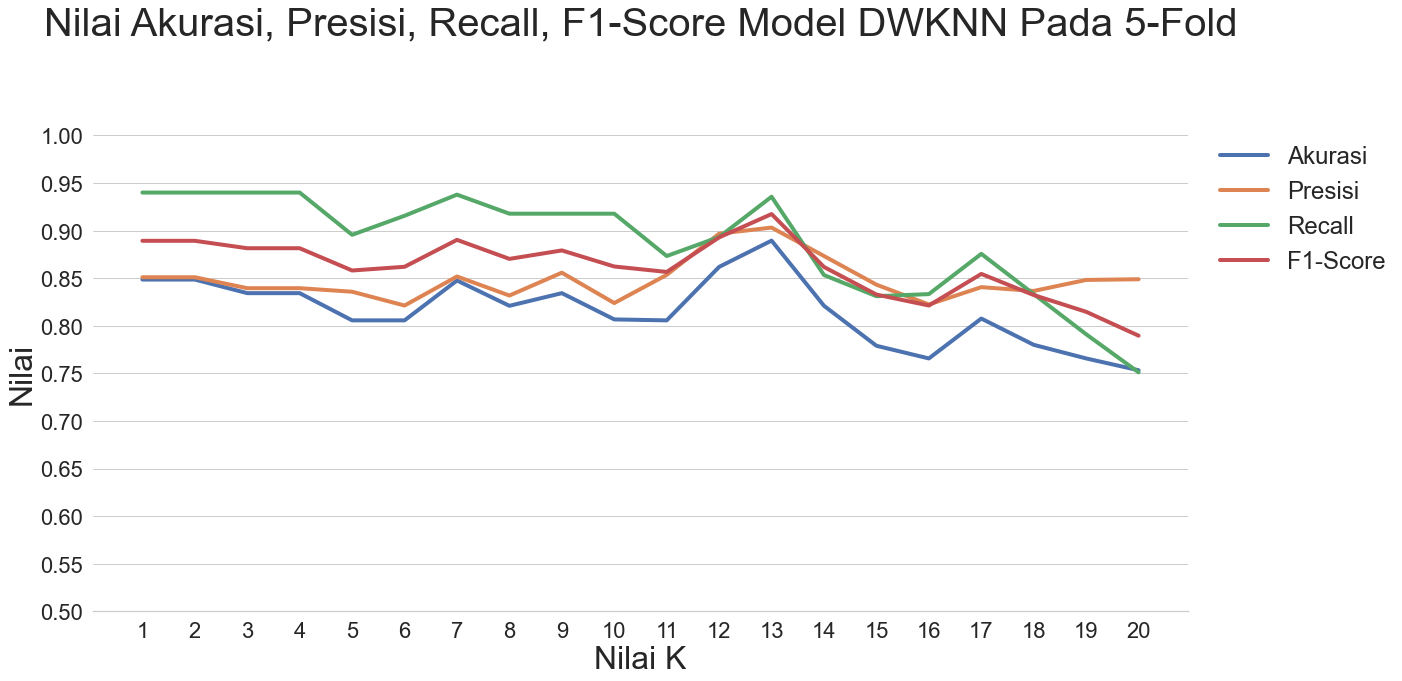

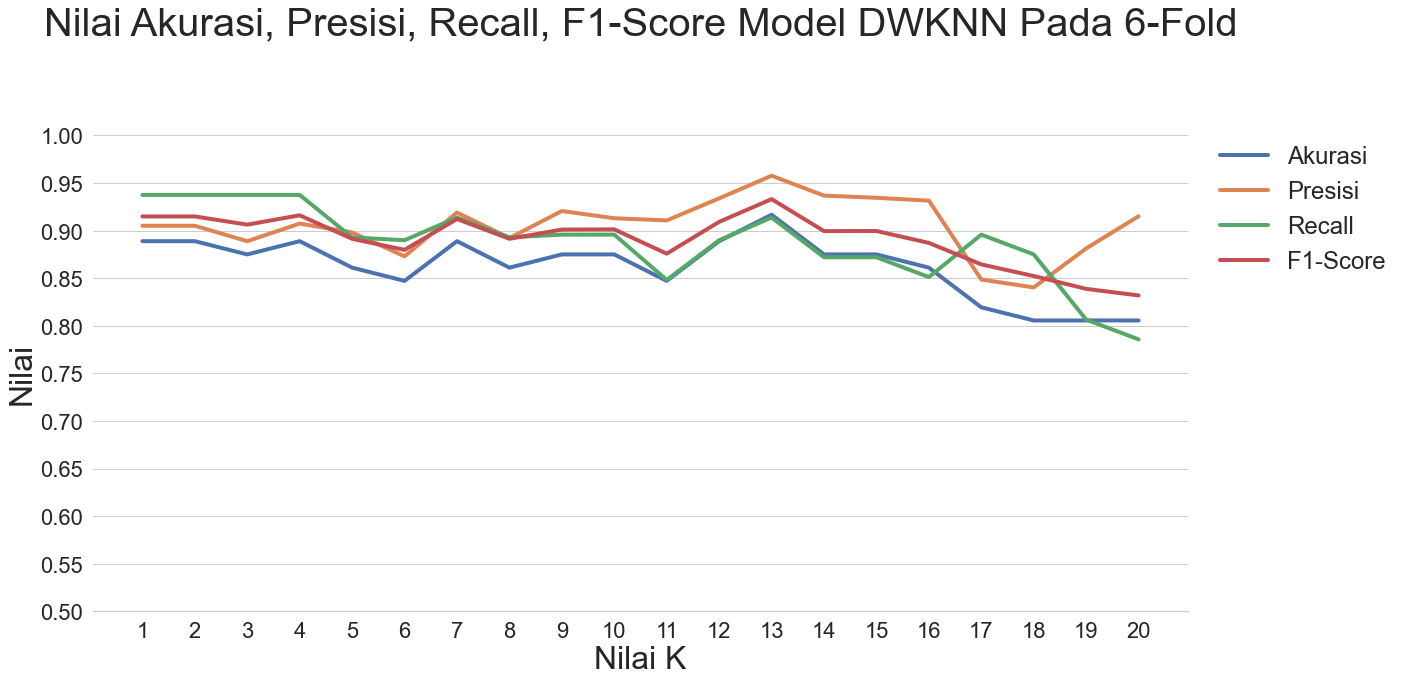

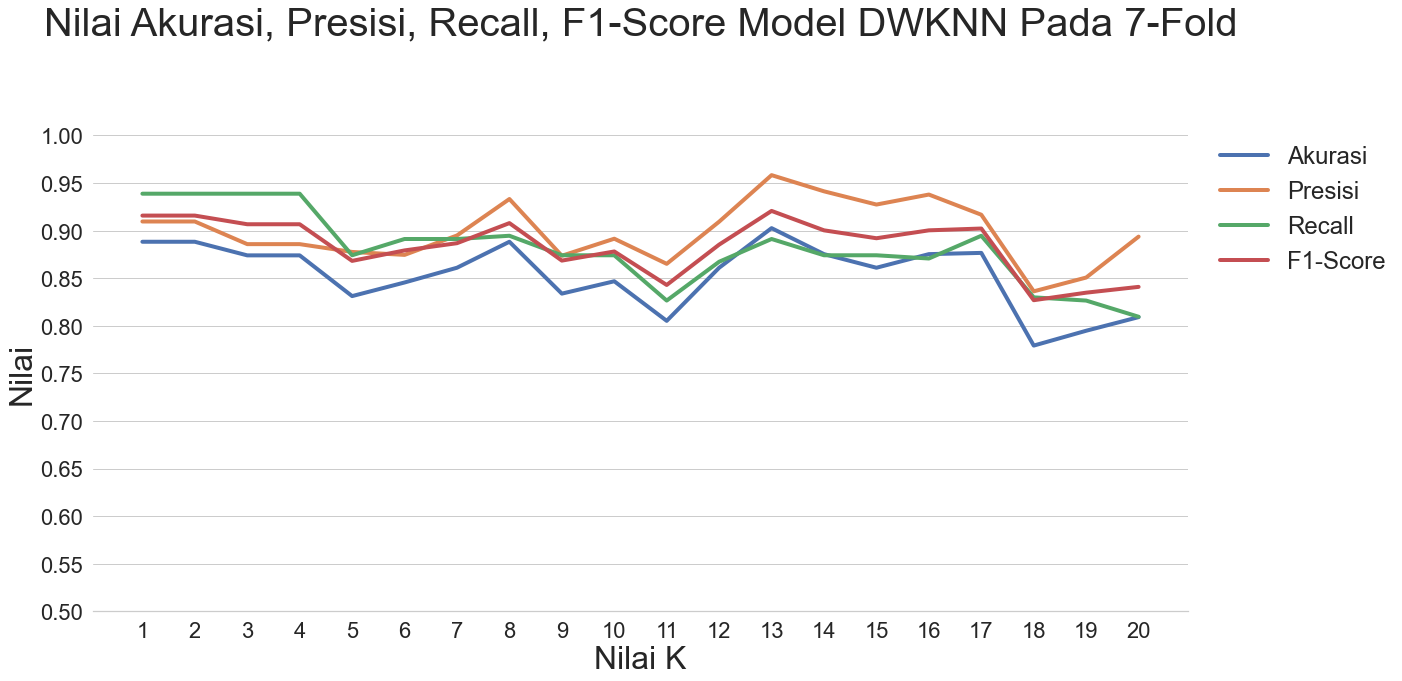

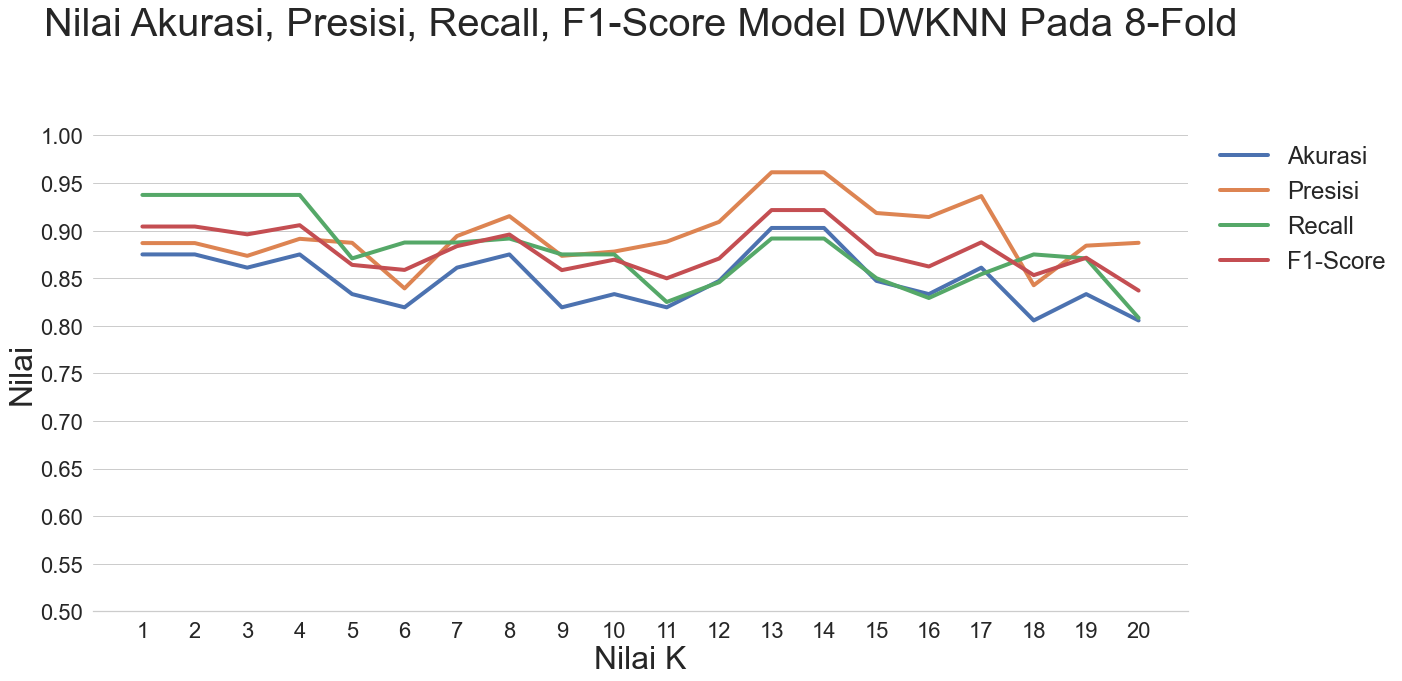

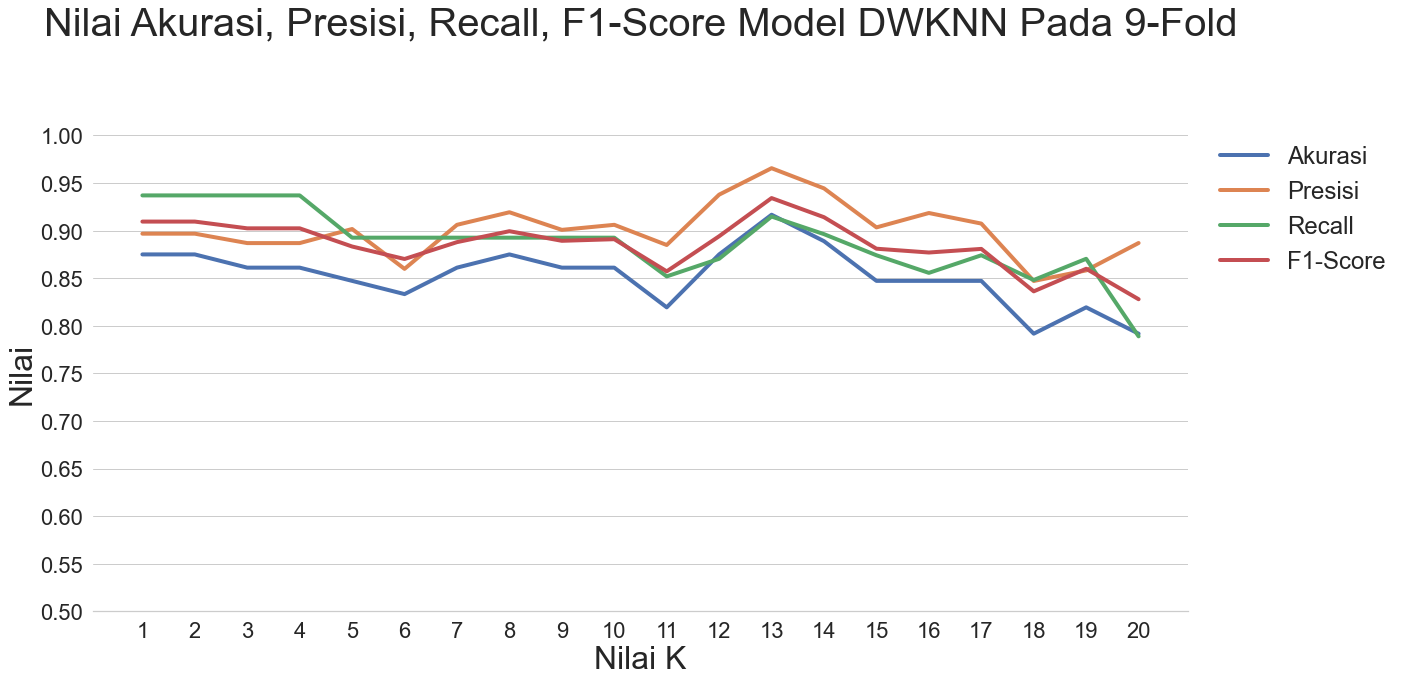

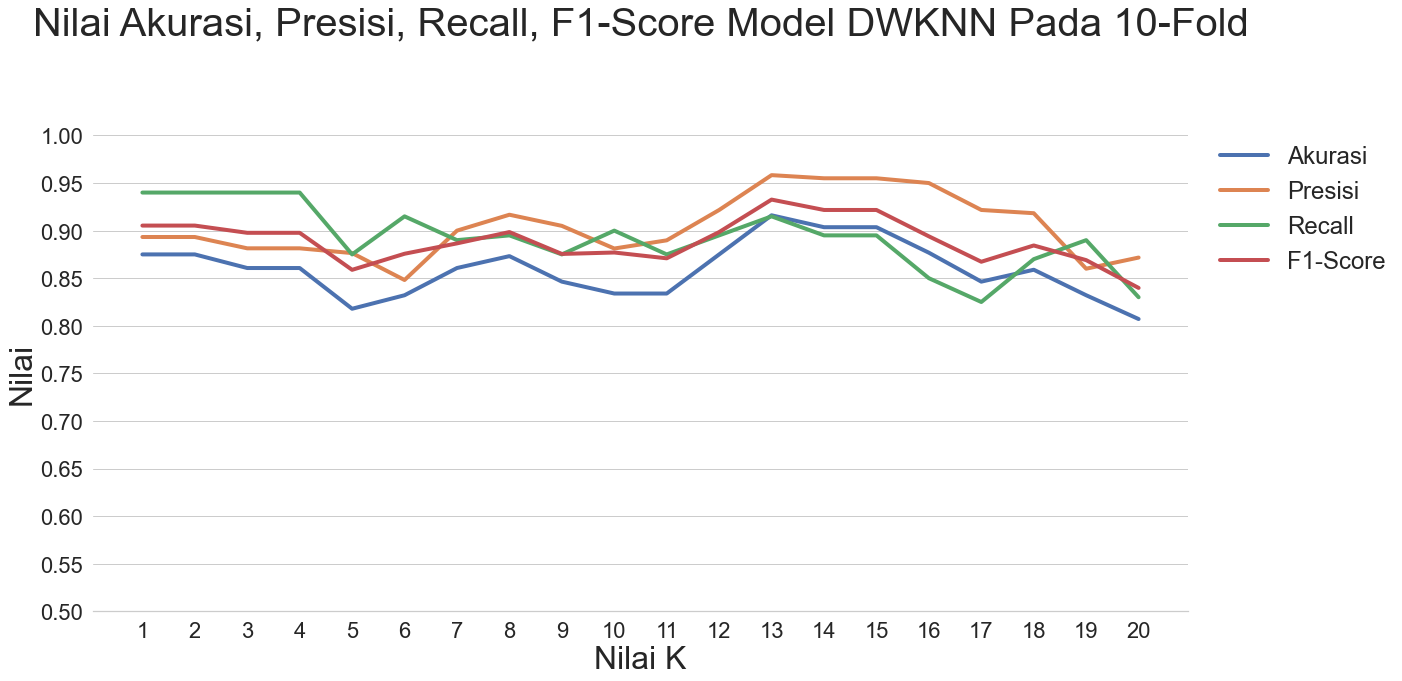

In [338]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Leukemia/DW Per Fold/DW {}-Fold.png'.format(i+2))

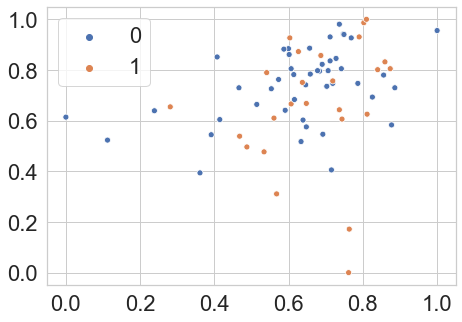

In [339]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,0], X[:,1], hue=y)
plt.show()

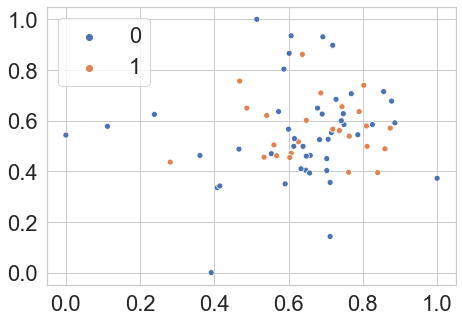

In [340]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,0], X[:,2], hue=y)
plt.show()

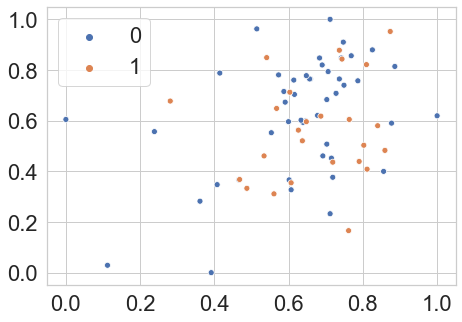

In [341]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,0], X[:,5], hue=y)
plt.show()

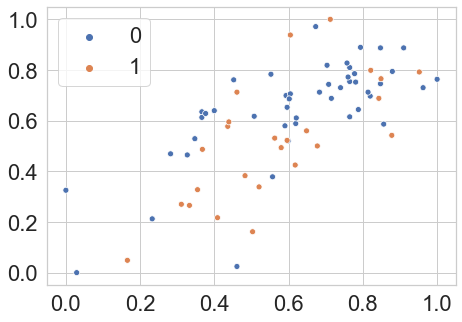

In [342]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,5], X[:,7], hue=y)
plt.show()

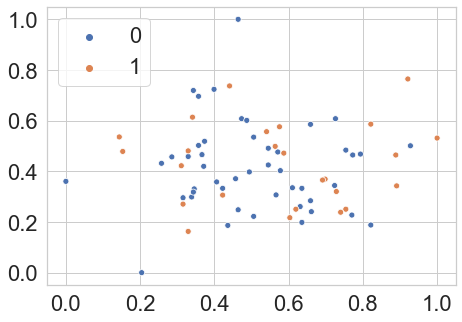

In [343]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,8], X[:,9], hue=y)
plt.show()

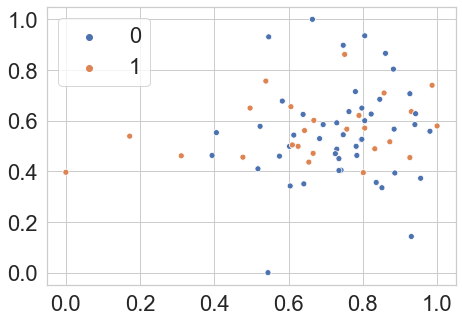

In [344]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,1], X[:,2], hue=y)
plt.show()

In [354]:
print(X_train_fold[0][0])

[[0.47 0.73 0.49 ... 0.75 0.08 0.57]
 [0.6  0.88 0.57 ... 0.68 0.04 0.66]
 [0.71 0.93 0.14 ... 0.77 0.09 0.56]
 ...
 [0.56 0.61 0.5  ... 0.64 0.09 0.77]
 [0.76 0.   0.4  ... 0.64 0.11 0.44]
 [0.53 0.48 0.46 ... 0.7  0.14 0.49]]


In [358]:
df_Xtrain2fold_iter1 = pd.DataFrame(X_train_fold[0][0])
df_Xtrain2fold_iter2 = pd.DataFrame(X_train_fold[0][1])

df_Xtest2fold_iter1 = pd.DataFrame(X_test_fold[0][0])
df_Xtest2fold_iter2 = pd.DataFrame(X_test_fold[0][1])

df_ytrain2fold_iter1 = pd.DataFrame(y_train_fold[0][0])
df_ytrain2fold_iter2 = pd.DataFrame(y_train_fold[0][1])

df_ytest2fold_iter1 = pd.DataFrame(y_test_fold[0][0])
df_ytest2fold_iter2 = pd.DataFrame(y_test_fold[0][1])

In [363]:
df_train_iter1 = pd.concat([df_Xtrain2fold_iter1, df_ytrain2fold_iter1], axis=1, join='inner')
df_train_iter1.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Hitungan/train_iter1.csv')
df_train_iter2 = pd.concat([df_Xtrain2fold_iter2, df_ytrain2fold_iter2], axis=1, join='inner')
df_train_iter2.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Hitungan/train_iter2.csv')

df_test_iter1 = pd.concat([df_Xtest2fold_iter1, df_ytest2fold_iter1], axis=1, join='inner')
df_test_iter1.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Hitungan/test_iter1.csv')
df_test_iter2 = pd.concat([df_Xtest2fold_iter2, df_ytest2fold_iter2], axis=1, join='inner')
df_test_iter2.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Hitungan/test_iter2.csv')

In [364]:
kfld_d_pred[0][3]

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1.])]